# Predicting the remaining useful life(time) of an engine

In this experiment we're trying to estimate the remaining useful life (RUL) of an engine (turbine).

The data provided by the NASA and available in several forms, see https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/ set 6 and 7. Here we're using dataset 6: Turbofan Engine Degradation Simulation Data Set. The dataset is well descibed though the enginevariables are not specified (to keep it interesting). For more information about the model of the engine, check out the 'User’s Guide for the Commercial Modular
Aero-Propulsion System Simulation (C-MAPSS)'. There are (at least) two version which can be found, latest? at https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20120003211.pdf.

I choose this example since it's one of the questions we're trying to answer in our machine monitoring platform so trying to learn how to do that. 

## Paper
The data is generated as part of the study as described in the paper 'Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation'.

## Citation
A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA

In [1]:
# Retrieve data set from the source
!wget https://ti.arc.nasa.gov/c/6/

--2019-02-26 14:53:54--  https://ti.arc.nasa.gov/c/6/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip [following]
--2019-02-26 14:53:56--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘index.html’

100%[======================================>] 12,425,978  9.79MB/s   in 1.2s   

2019-02-26 14:53:57 (9.79 MB/s) - ‘index.html’ saved [12425978/12425978]



In [2]:
# mmm, naming not as expected
!mv index.html CMAPSSData.zip

In [3]:
# Lets create specific directory
!mkdir rul-cmapssdata

In [4]:
# Have a look into the data
!unzip CMAPSSData.zip -d rul-cmapssdata

Archive:  CMAPSSData.zip
  inflating: rul-cmapssdata/Damage Propagation Modeling.pdf  
  inflating: rul-cmapssdata/readme.txt  
  inflating: rul-cmapssdata/RUL_FD001.txt  
  inflating: rul-cmapssdata/RUL_FD002.txt  
  inflating: rul-cmapssdata/RUL_FD003.txt  
  inflating: rul-cmapssdata/RUL_FD004.txt  
  inflating: rul-cmapssdata/test_FD001.txt  
  inflating: rul-cmapssdata/test_FD002.txt  
  inflating: rul-cmapssdata/test_FD003.txt  
  inflating: rul-cmapssdata/test_FD004.txt  
  inflating: rul-cmapssdata/train_FD001.txt  
  inflating: rul-cmapssdata/train_FD002.txt  
  inflating: rul-cmapssdata/train_FD003.txt  
  inflating: rul-cmapssdata/train_FD004.txt  


From the readme we learn that we have *4* data sets, each with its own characteristics:

### Data sets
| Data Set  | Train trajectories   | Test trajectories   | Conditions      | Fault Modes                             |
| --------- |:-------------------- |:------------------- | ---------------:|:--------------------------------------  |
| FD001     | 100                  | 100                 | ONE (Sea Level) | ONE (HPC Degradation)                   |
| FD002     | 260                  | 259                 | SIX             | ONE (HPC Degradation)                   |
| FD003     | 100                  | 100                 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation)  |
| FD004     | 248                  | 249                 | SIX             | TWO (HPC Degradation, Fan Degradation)  |

The readme also desribes the scenarios...

### Experimental Scenario

Each dataset consists of multiple multivariate time series and is further divided into training and testsets. Each timeseries is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user (or the data explorer). This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

### Engine data

Each set contains data of multiple engines, each engine having the following data:

1)	unit number            <br/>
2)	time, in cycles        <br/>
3)	operational setting 1  <br/>
4)	operational setting 2  <br/>
5)	operational setting 3  <br/>
6)	sensor measurement  1  <br/>
7)	sensor measurement  2  <br/>
...                        <br/>
25)	sensor measurement  20 <br/>
 
Note: the description contains a minor error concerning the number of sensor measurements.




The simulated engine is shown below:<br>

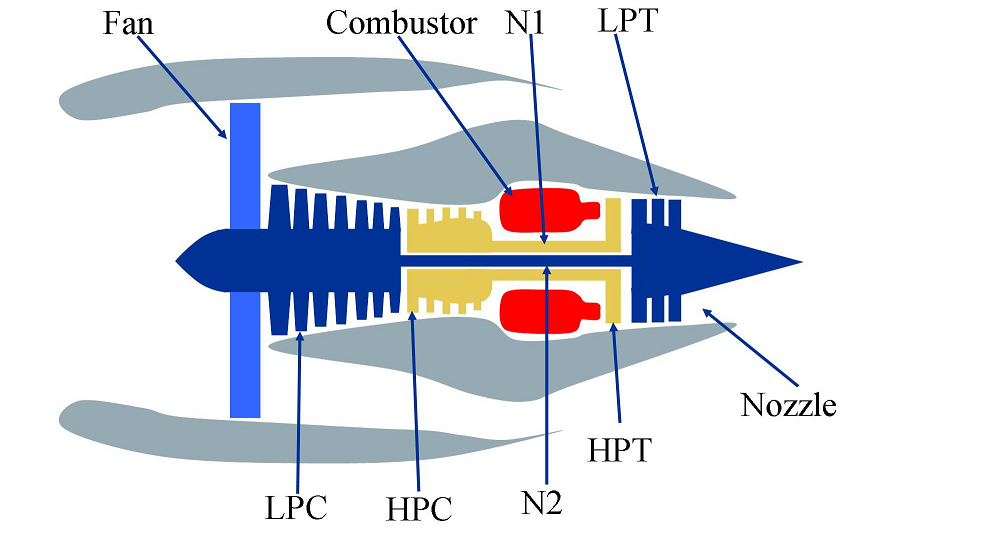


In [5]:
# lets have a look at the first dataset
!head rul-cmapssdata/train_FD001.txt

1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82 1403.14 14.62 21.61 553.75 2388.04 9044.07 1.30 47.49 522.28 2388.07 8131.49 8.4318 0.03 392 2388 100.00 39.00 23.4236  
1 3 -0.0043 0.0003 100.0 518.67 642.35 1587.99 1404.20 14.62 21.61 554.26 2388.08 9052.94 1.30 47.27 522.42 2388.03 8133.23 8.4178 0.03 390 2388 100.00 38.95 23.3442  
1 4 0.0007 0.0000 100.0 518.67 642.35 1582.79 1401.87 14.62 21.61 554.45 2388.11 9049.48 1.30 47.13 522.86 2388.08 8133.83 8.3682 0.03 392 2388 100.00 38.88 23.3739  
1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.85 1406.22 14.62 21.61 554.00 2388.06 9055.15 1.30 47.28 522.19 2388.04 8133.80 8.4294 0.03 393 2388 100.00 38.90 23.4044  
1 6 -0.0043 -0.0001 100.0 518.67 642.10 1584.47 1398.37 14.62 21.61 554.67 2388.02 9049.68 1.30 47.16 521.68 2388.03 8132.85 8.4108 0.03 391 2388 100.00 38.98 

The data is delivered without any header so we need to reconstruct, using the readme.txt.

To get started, lets read the first set: FD001.

In [6]:
# check spark version, just to be sure
sc.version

'2.1.3'

In [7]:
# and the python version
!python --version

Python 3.5.4 :: Anaconda, Inc.


In [8]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

# recreate structure based on readme.
schema = StructType([
    StructField("unit"    , IntegerType(), True),
    StructField("cycle"   , IntegerType(), True),
    StructField("opset1"  , FloatType(), True),
    StructField("opset2"  , FloatType(), True),
    StructField("opset3"  , FloatType(), True),
    StructField("sensor01", FloatType(), True),
    StructField("sensor02", FloatType(), True),
    StructField("sensor03", FloatType(), True),
    StructField("sensor04", FloatType(), True),
    StructField("sensor05", FloatType(), True),
    StructField("sensor06", FloatType(), True),
    StructField("sensor07", FloatType(), True),
    StructField("sensor08", FloatType(), True),
    StructField("sensor09", FloatType(), True),
    StructField("sensor10", FloatType(), True),
    StructField("sensor11", FloatType(), True),
    StructField("sensor12", FloatType(), True),
    StructField("sensor13", FloatType(), True),
    StructField("sensor14", FloatType(), True),
    StructField("sensor15", FloatType(), True),
    StructField("sensor16", FloatType(), True),
    StructField("sensor17", FloatType(), True),
    StructField("sensor18", FloatType(), True),
    StructField("sensor19", FloatType(), True),
    StructField("sensor20", FloatType(), True),
    StructField("sensor21", FloatType(), True)])

In [9]:
# lets load the data, only one file
df_train_fd001 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/train_FD001.txt', schema=schema)

# also test for later
df_test_fd001 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/test_FD001.txt', schema=schema)

In [10]:
# check the loaded dataset
df_train_fd001.show()

+----+-----+-------+-------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|unit|cycle| opset1| opset2|opset3|sensor01|sensor02|sensor03|sensor04|sensor05|sensor06|sensor07|sensor08|sensor09|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|
+----+-----+-------+-------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   1|    1|-7.0E-4|-4.0E-4| 100.0|  518.67|  641.82|  1589.7|  1400.6|   14.62|   21.61|  554.36| 2388.06| 9046.19|     1.3|   47.47|  521.66| 2388.02| 8138.62|  8.4195|    0.03|   392.0|  2388.0|   100.0|   39.06|  23.419|
|   1|    2| 0.0019|-3.0E-4| 100.0|  518.67|  642.15| 1591.82| 1403.14|   14.62|   21.61|  553.75| 2

The data as such doesn't tell us too much, mainly because we don't know what a sensor measures, though we can guess that some will be measuring RPM and others a temperature.<br>
Let first check for missing values.

In [11]:
# check the loaded test data
df_test_fd001.show()

+----+-----+-------+-------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|unit|cycle| opset1| opset2|opset3|sensor01|sensor02|sensor03|sensor04|sensor05|sensor06|sensor07|sensor08|sensor09|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|
+----+-----+-------+-------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   1|    1| 0.0023| 3.0E-4| 100.0|  518.67|  643.02| 1585.29| 1398.21|   14.62|   21.61|   553.9| 2388.04| 9050.17|     1.3|    47.2|  521.72| 2388.03| 8125.55|  8.4052|    0.03|   392.0|  2388.0|   100.0|   38.86| 23.3735|
|   1|    2|-0.0027|-3.0E-4| 100.0|  518.67|  641.71| 1588.45| 1395.42|   14.62|   21.61|  554.85| 2

In [12]:
# Check for missing data
print('Total number of rows in dataset {0}.'.format( df_train_fd001.count()))

# check for each column
from pyspark.sql.functions import col,sum

df_train_fd001.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_train_fd001.columns)).show()

Total number of rows in dataset 20631.
+----+-----+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|unit|cycle|opset1|opset2|opset3|sensor01|sensor02|sensor03|sensor04|sensor05|sensor06|sensor07|sensor08|sensor09|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|
+----+-----+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   0|    0|     0|     0|     0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
+----+-----+------+------+------+--------+--------+--------+--------+

There doesn't seem to be missing data, other issues may still occur. Lets examine the data in this set more closely by calculating the statistics for each column in the dataset...<br>
We will do that in several steps to keep the text / tables readable...

In [13]:
# stats of each column, gets messy so we go trhough subsets
df_train_fd001.select('unit', 'cycle','opset1','opset2','opset3').describe().show()

+-------+------------------+------------------+--------------------+--------------------+------+
|summary|              unit|             cycle|              opset1|              opset2|opset3|
+-------+------------------+------------------+--------------------+--------------------+------+
|  count|             20631|             20631|               20631|               20631| 20631|
|   mean|51.506567786340945|108.80786195530997|-8.87014690643805E-6|2.350831444939129...| 100.0|
| stddev| 29.22763290879931| 68.88099017721827|0.002187313456274...|2.930621282268445...|   0.0|
|    min|                 1|                 1|             -0.0087|             -6.0E-4| 100.0|
|    max|               100|               362|              0.0087|              6.0E-4| 100.0|
+-------+------------------+------------------+--------------------+--------------------+------+



First glance: we have 100 units, i.e. engines and max 362 cycles. Note that the number of cycles clearly varies. It seems that we dont have an precise fit, i.e. the number of engines * the number of cycles = 23600 != 20631.<br>
the operational seetings dont tell us much, except the the operational setting number 3 was fixed at 100.<br>

Lets have a baisc peek at the senor data.

In [14]:
# stats of each column, gets messy so we go through subsets
df_train_fd001.select('sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10').describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+------------------+
|summary|         sensor01|          sensor02|          sensor03|          sensor04|          sensor05|            sensor06|          sensor07|           sensor08|          sensor09|          sensor10|
+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+------------------+
|  count|            20631|             20631|             20631|             20631|             20631|               20631|             20631|              20631|             20631|             20631|
|   mean|518.6699829101562| 642.6809336159499|1590.5231185350247|1408.9337815859817|14.619999885559082|   21.60980381461088| 553.3677112379098| 2388.0966671082997| 9065.242942630704|1.29999995

In [15]:
# stats of each column, gets messy so we go through subsets
df_train_fd001.select('sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21').describe().show()

+-------+-------------------+------------------+-------------------+------------------+-------------------+--------------------+------------------+--------+--------+------------------+-------------------+
|summary|           sensor11|          sensor12|           sensor13|          sensor14|           sensor15|            sensor16|          sensor17|sensor18|sensor19|          sensor20|           sensor21|
+-------+-------------------+------------------+-------------------+------------------+-------------------+--------------------+------------------+--------+--------+------------------+-------------------+
|  count|              20631|             20631|              20631|             20631|              20631|               20631|             20631|   20631|   20631|             20631|              20631|
|   mean|  47.54116813578681| 521.4134698220366|   2388.09616776256| 8143.752723047803|  8.442145583344283|0.029999999329447746| 393.2106538703892|  2388.0|   100.0| 38.81627065749

So since the operational setting number 3, and sensor 01, 05, 10, 16, 18 and 19 all have a fixed seting we can drop them from this set.. But what about the other sets?
Later we might merge the data sets, after we added the columns 'condition' and 'fault mode', based on the given readme.<cr>
First we inspect data set FD001.

To get some idea about the data, lets examine just one sensor (sensor02 in this case) of one engine.

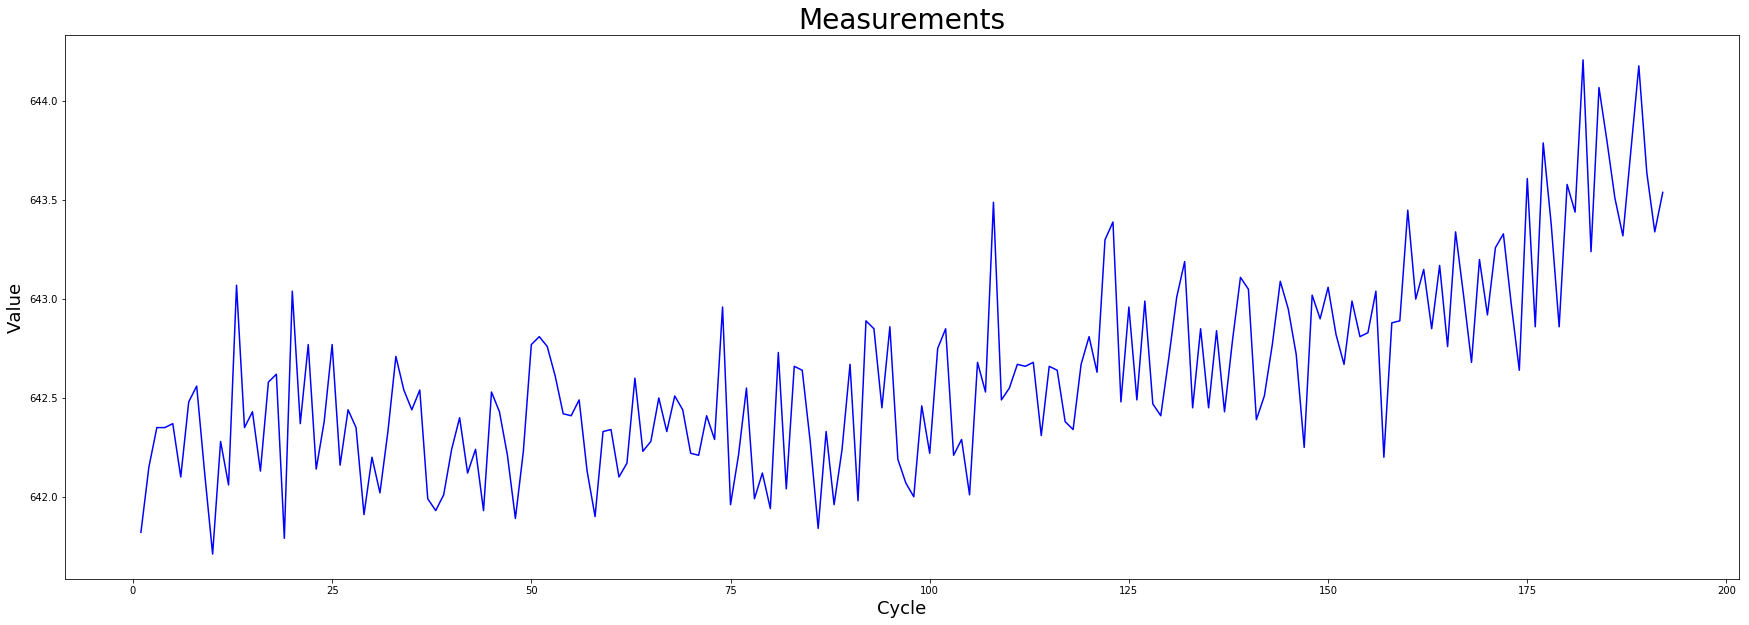

In [16]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

subset = df_train_fd001.select('unit', 'cycle', 'sensor02').where("unit == 1").toPandas()
subset.plot(figsize = (30,10), kind = "line", color = "blue", x = "cycle", y = "sensor02", legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("Measurements", fontsize = 28)

plt.show()

Looks like there is somekind of trend (upwards) visible. Lets have a look at sensor02 of all the engines.<br/>
**todo plot trend (non linear).**

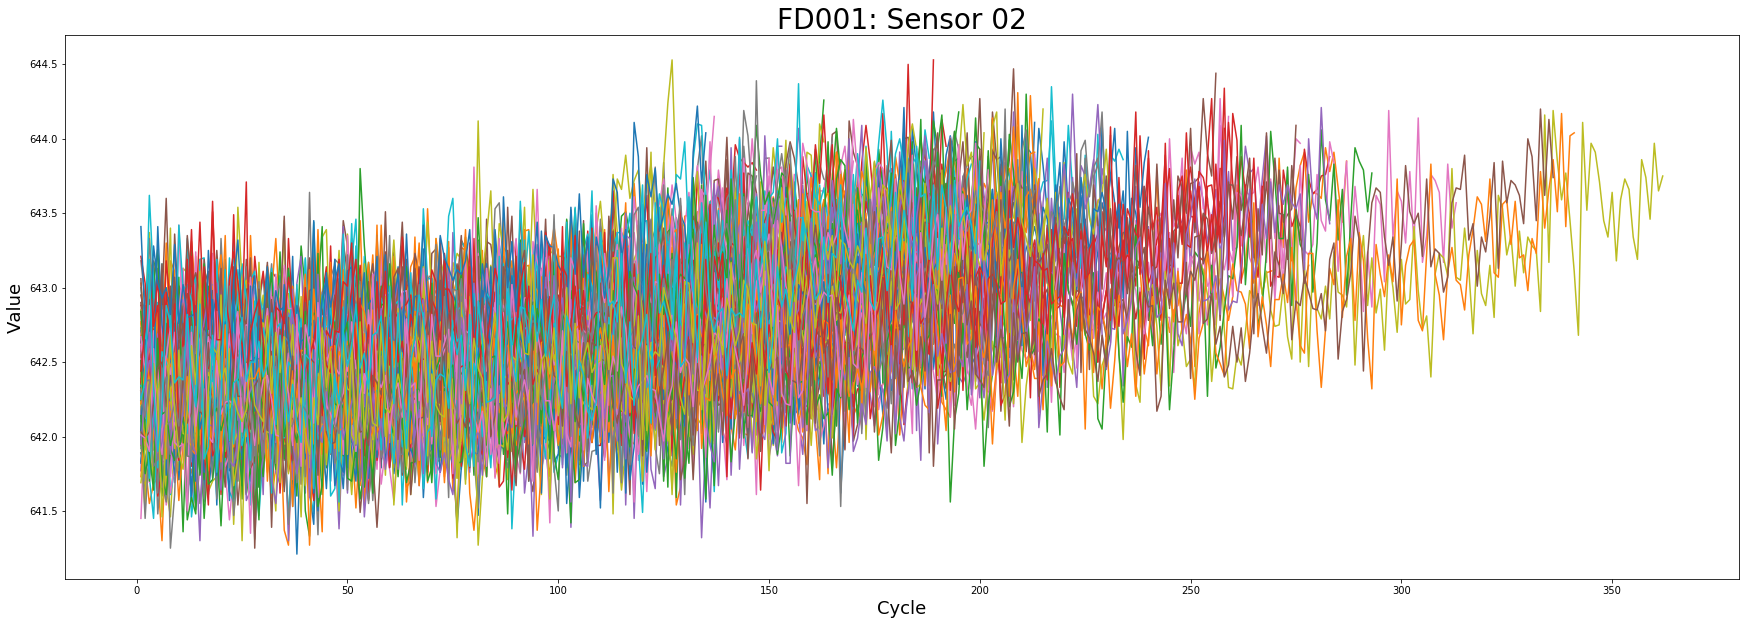

In [17]:
fig, ax = plt.subplots()

subset = df_train_fd001.select('unit', 'cycle', 'sensor02').toPandas()
# print(subset.groupby(['unit']).head())
#       unit  cycle    sensor02
#0         1      1  641.820007
#1         1      2  642.150024
#2         1      3  642.349976
#3         1      4  642.349976

for cycle, sensor in subset.groupby(['unit']):
    ax = sensor.plot(figsize = (30,10), ax=ax, kind='line', x='cycle', y='sensor02', legend=False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("FD001: Sensor 02", fontsize = 28)

plt.show()

Still seems to show a trend. Clearly not all runs last for the same number of cycles.<br>
Lets examine a sensor with a large(r) standard deviations... Sensor 3 for example.

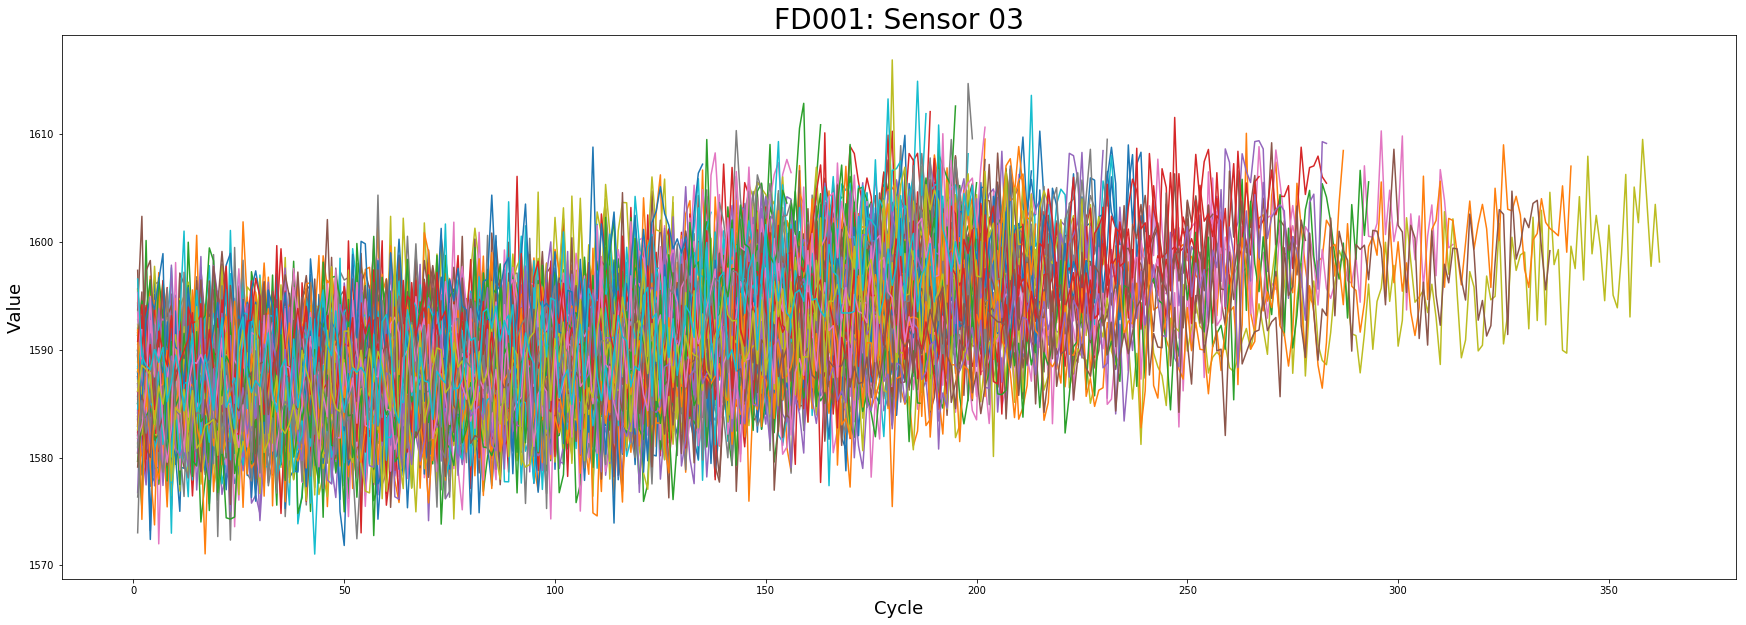

In [18]:
fig, ax = plt.subplots()

subset = df_train_fd001.select('unit', 'cycle', 'sensor03').toPandas()

for cycle, sensor in subset.groupby(['unit']):
    ax = sensor.plot(figsize = (30,10), ax=ax, kind='line', x='cycle', y='sensor03', legend=False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("FD001: Sensor 03", fontsize = 28)


plt.show()

Show somekind of upwards trend. But nog very clearly. Checking on yet another sensor.

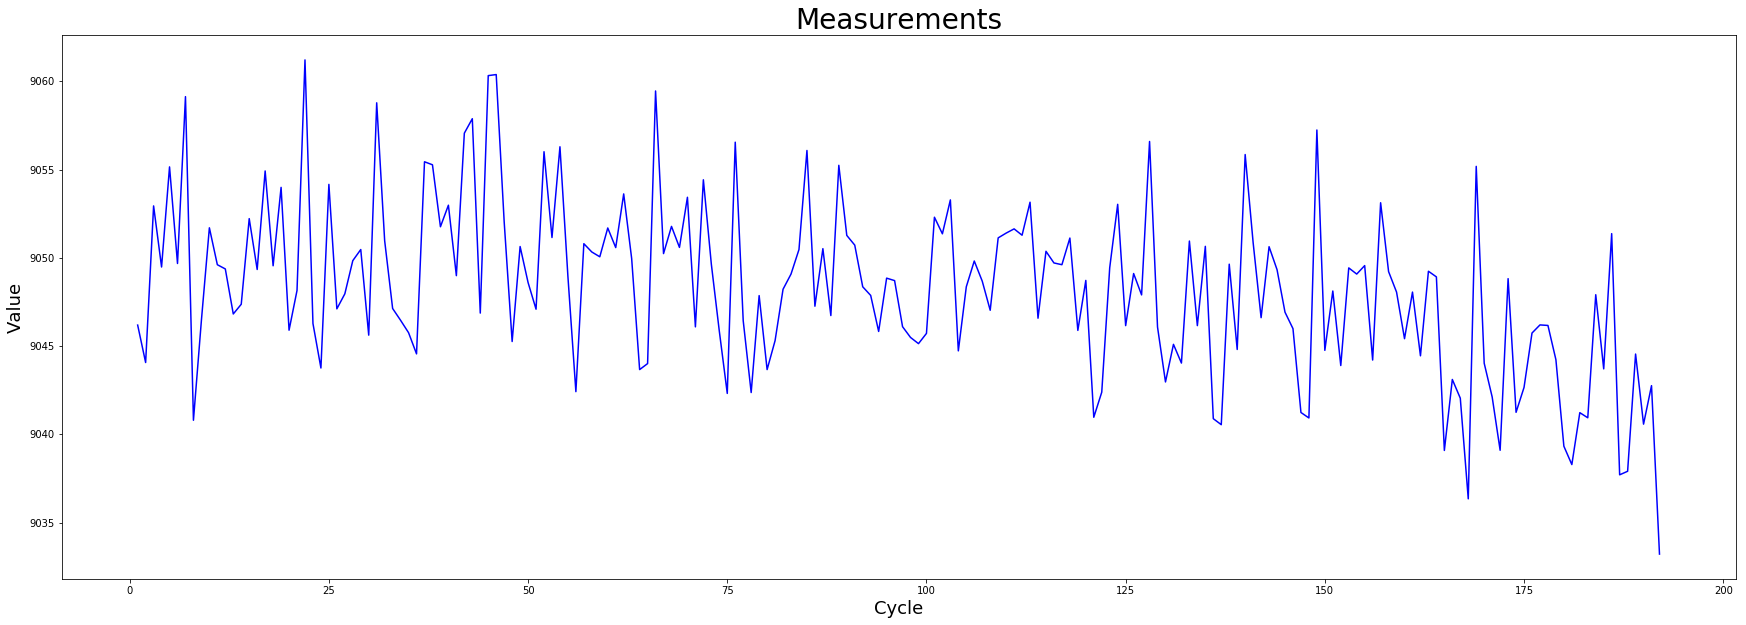

In [19]:
subset = df_train_fd001.select('unit', 'cycle', 'sensor09').where("unit == 1").toPandas()
subset.plot(figsize = (30,10), kind = "line", color = "blue", x = "cycle", y = "sensor09", legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("Measurements", fontsize = 28)

plt.show()

There is a lot of data to browse through, so far we only checked some data of the first set out of the 4. What about the operational settings, let's check one (which isn't at a fixed value).

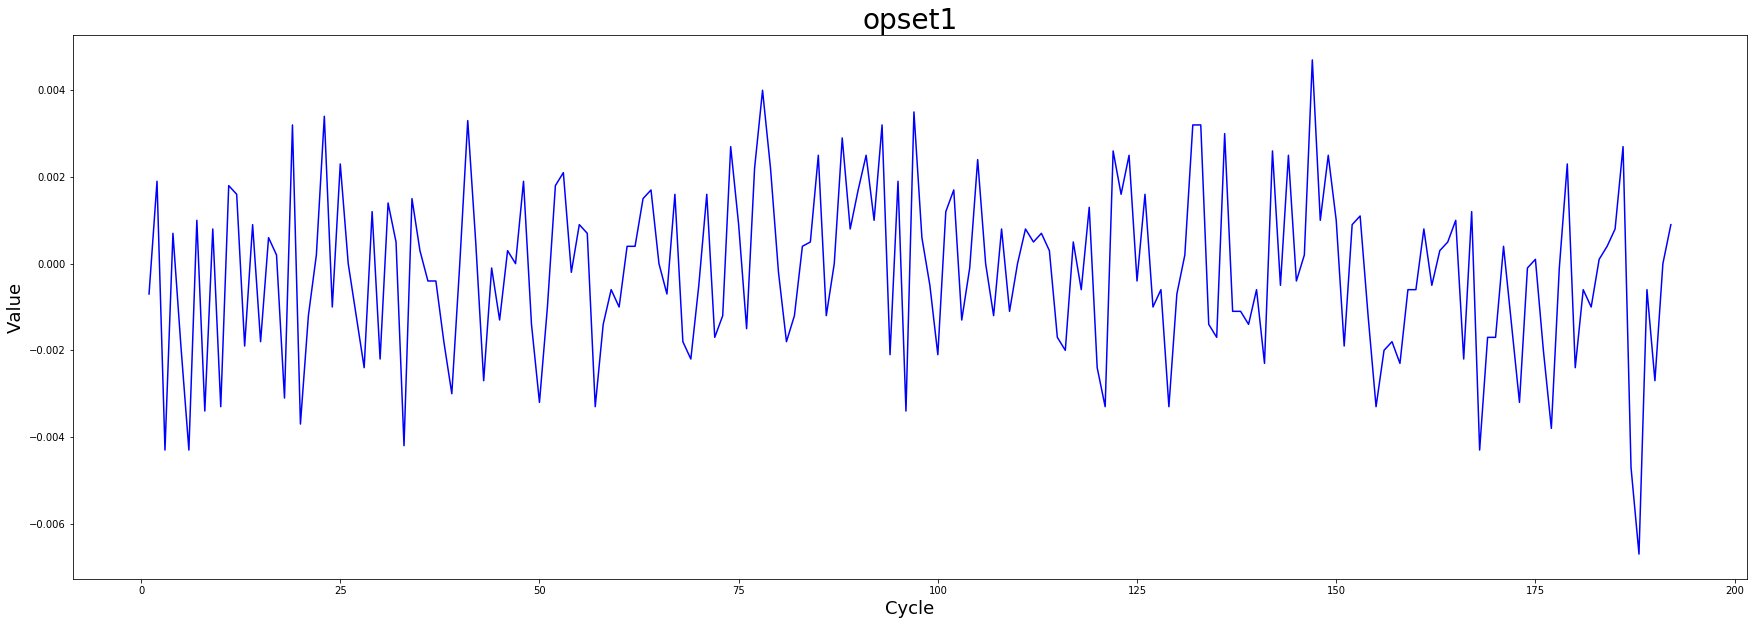

In [20]:
# can we learn somethig from the operatinal settings
subset = df_train_fd001.select('unit', 'cycle', 'opset1').where("unit == 1").toPandas()
subset.plot(figsize = (30,10), kind = "line", color = "blue", x = "cycle", y = "opset1", legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("opset1", fontsize = 28)

plt.show()

Operational settings varies a lot over time (i.e. cycles)

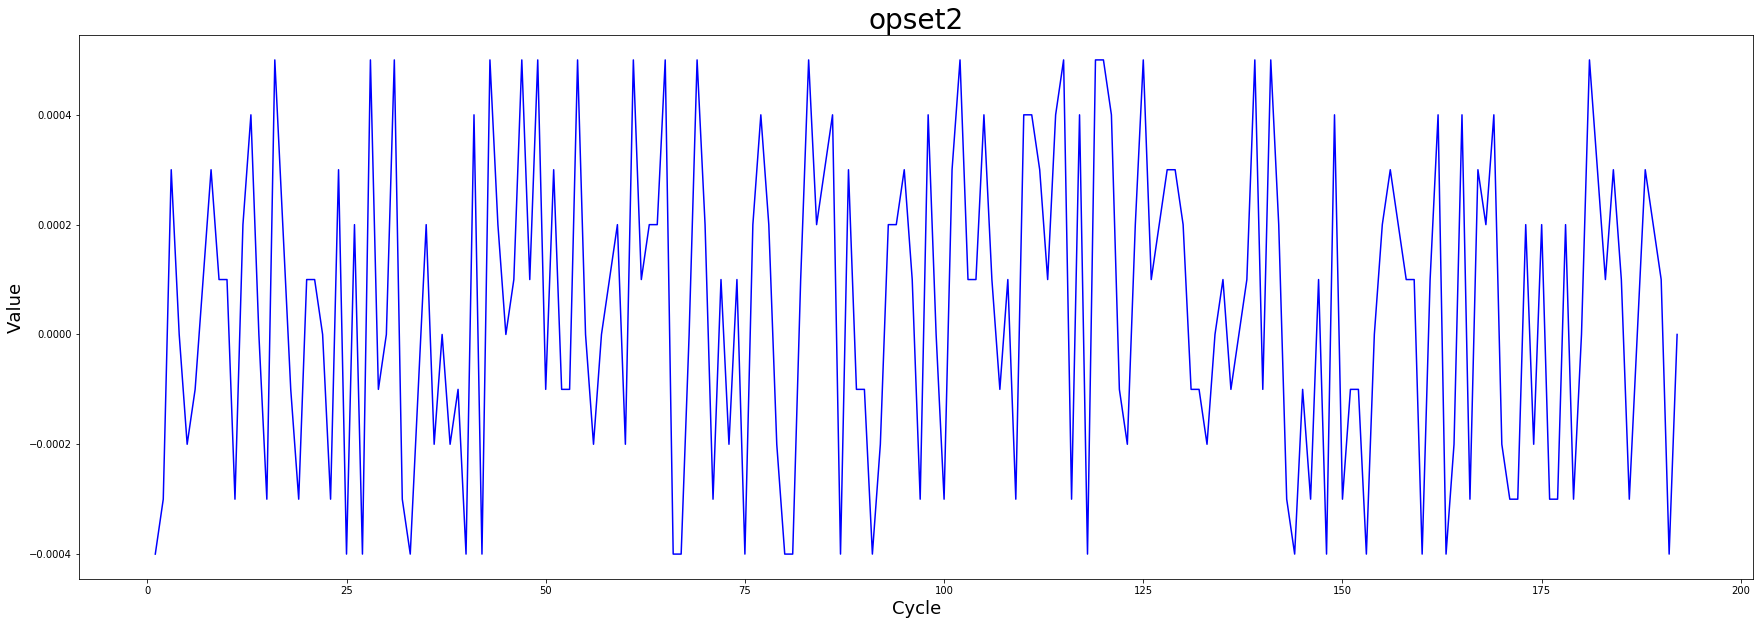

In [21]:
# can we learn something from the operational settings
subset = df_train_fd001.select('unit', 'cycle', 'opset2').where("unit == 1").toPandas()
subset.plot(figsize = (30,10), kind = "line", color = "blue", x = "cycle", y = "opset2", legend = False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("opset2", fontsize = 28)

plt.show()

Hard to draw any conclusions from the operational settings as such.

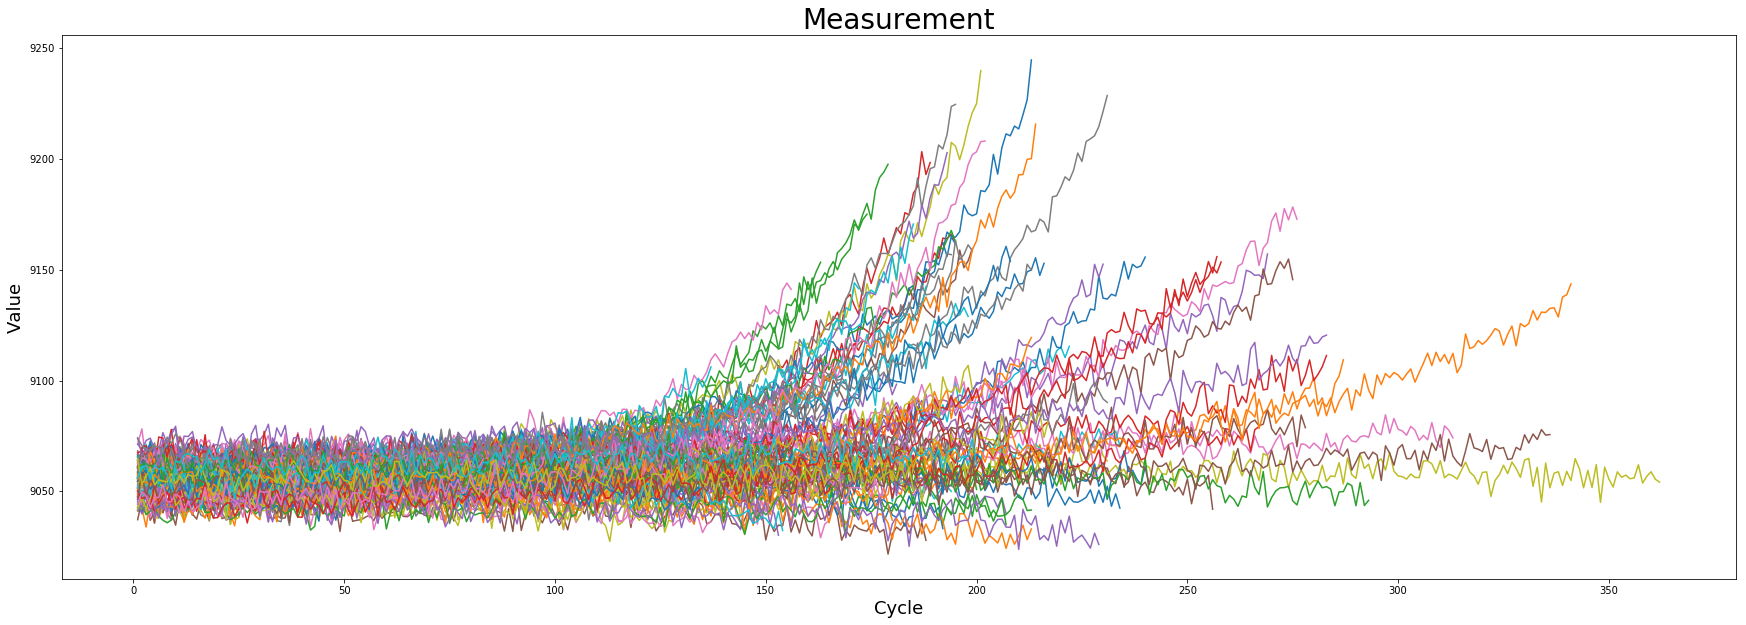

In [22]:
fig, ax = plt.subplots()

subset = df_train_fd001.select('unit', 'cycle', 'sensor09').toPandas()

for cycle, sensor in subset.groupby(['unit']):
    ax = sensor.plot(figsize = (30,10), ax=ax, kind='line', x='cycle', y='sensor09', legend=False)

plt.xlabel("Cycle", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.title("Measurement", fontsize = 28)


plt.show()

Sensor 09 is one example where we see a change in value though it has a larger spread as compared to sensor02 or senso03. Lets check if we can find a statistical correlation between several sensors.<br/>
Even for this small dataset its hard to go through like this, so we go for a more statistical approach.<br/>

How about the form/distribution of a feature? Histograms groups data into bins and provides a count of the number of observations in each bin. The shape of the bins gives an impression whether an attribute is Gaussian’, skewed or another perhaps an exponential distribution. It can also help you see possible outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff907464e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7eff6081ecf8>]], dtype=object)

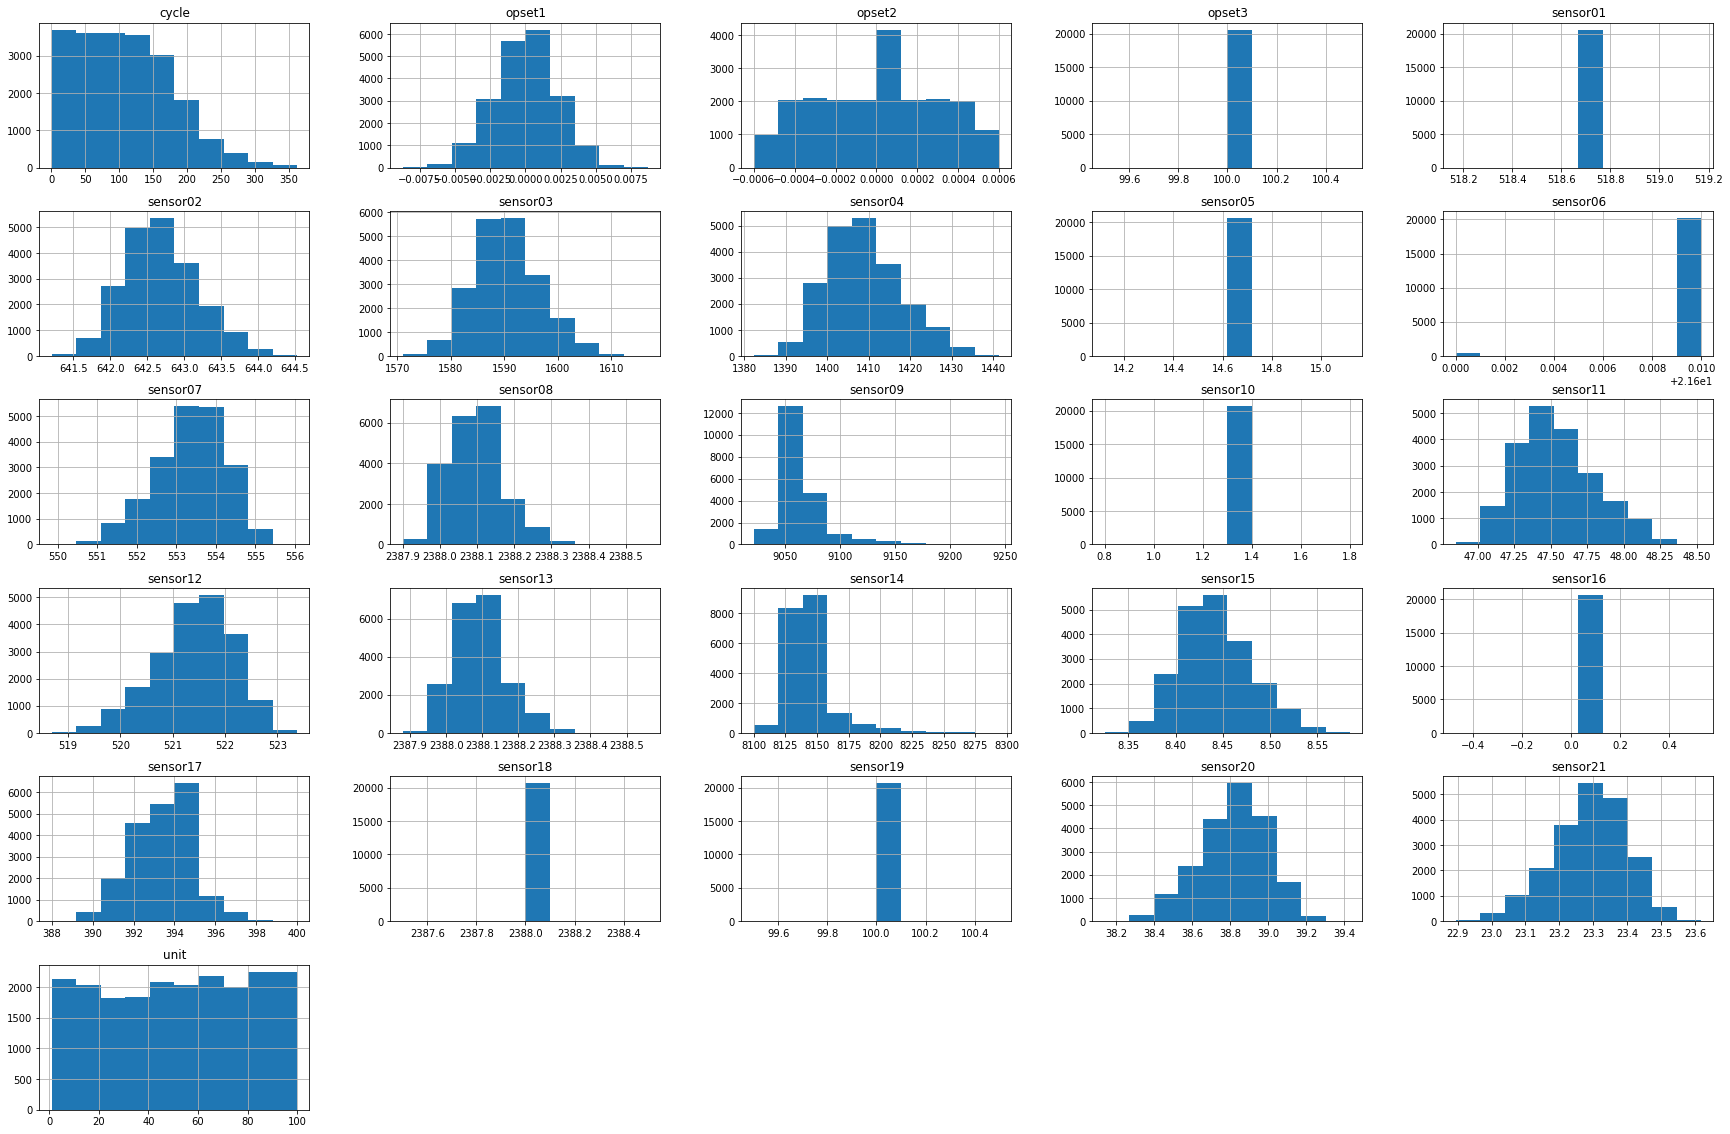

In [23]:
# just a quick view.
pd_train_fd001 = df_train_fd001.toPandas()
pd_train_fd001.hist(figsize = (30,20))

Apparently lot of sensor data is a bit skewed. Most of the sensors don't fit a nice bell shape (normal distribution). Additionally, we may review the distribution of each attribute using Box and Whisker Plots (boxplots). <br/>
Boxplots summarize the distribution of each attribute, drawing a line for the median (middle value) and a box around the 25th and 75th percentiles (the middle 50% of the data).
The whiskers give an idea of the spread of the data and dots outside of the whiskers show candidate outlier values (values that are 1.5 times greater than the size of spread of the middle 50% of the data).

**TODO/Question: should we do this for all datasets combined?** <br/>

**Note: we can ignore unit (the engine number) and cycle (time step) since they are not related to measurements or operational settings.**<br/>

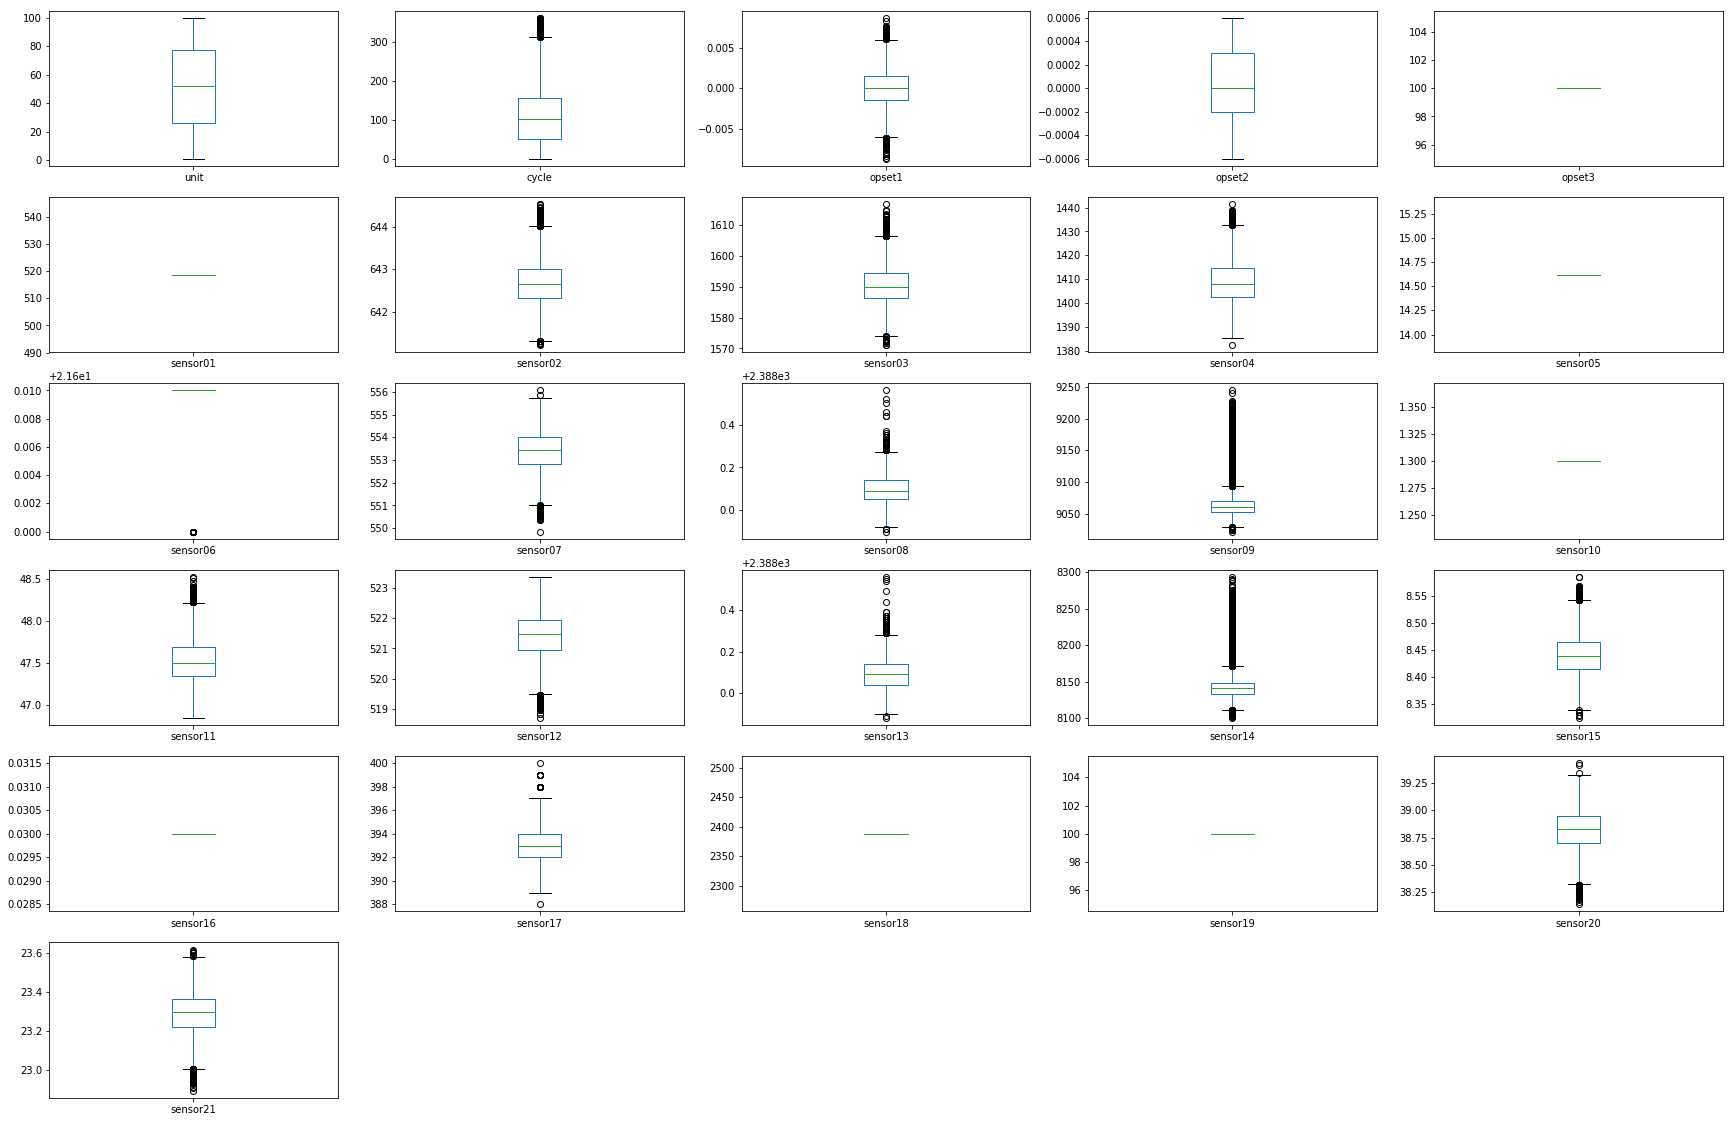

In [24]:
pd_train_fd001.plot(figsize = (30,20), kind='box', subplots=True, layout=(6,5), sharex=False, sharey=False)
plt.show()

So what does it tell us? For example, sensor09 has a skewed distribution, a large standard deviation and seems to have a lot of outliers... And given the fact it has a large spread its hard to learn anythng from it, except that at the beginning (of a run, i.e. about the first 100 cycles the values seem close and start to deviate over the runs after that. So we should look to the variation in time to get the picture.

Sensors like sensor 10 dont seem to add much value to the data set, they're stuck to a certain value.

So besides those sensors can we safely drop others from the set, how to they correlate? <br/>
**Todo: should we remove outliers (i.e. filter) ?**

In [25]:
# had to check for pandas version so i use the right version of the documentation.
pd.__version__

'0.21.0'

In [26]:
# since we have many features a correlation matrix or scatterplot is hard to get plotted.
# a 25 * 25 comparison results in 625 figures, perhaps use a subset? 
# or just the matrix 
pd.set_option('display.width', 800) # doesnt help to show all at once...

correlations = pd_train_fd001.corr()
print(correlations)

              unit     cycle    opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05    ...     sensor12  sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21
unit      1.000000  0.078753 -0.017895 -0.006197     NaN       NaN  0.014133  0.012621  0.026116       NaN    ...    -0.031882  0.044268 -0.059474  0.022486       NaN  0.013513       NaN       NaN -0.020589 -0.016465
cycle     0.078753  1.000000 -0.004527  0.016132     NaN       NaN  0.549898  0.543947  0.624577       NaN    ...    -0.611354  0.477498  0.370324  0.588676       NaN  0.566995       NaN       NaN -0.583597 -0.585923
opset1   -0.017895 -0.004527  1.000000  0.011660     NaN       NaN  0.009030 -0.005651  0.009544       NaN    ...    -0.001491  0.002318 -0.004469  0.007652       NaN  0.002599       NaN       NaN -0.005713 -0.014559
opset2   -0.006197  0.016132  0.011660  1.000000     NaN       NaN  0.007266  0.009068  0.014673       NaN    ...    -0.010923  0.01

In [27]:
import numpy as np

# drop one halve of the matrix
corr_triu = correlations.where(~np.tril(np.ones(correlations.shape)).astype(np.bool))
corr_triu = corr_triu.stack()

# drop correlations below 0.3
corr_triu[corr_triu > 0.3]

cycle     sensor02    0.549898
          sensor03    0.543947
          sensor04    0.624577
          sensor08    0.475950
          sensor09    0.443999
          sensor11    0.634385
          sensor13    0.477498
          sensor14    0.370324
          sensor15    0.588676
          sensor17    0.566995
sensor02  sensor03    0.602610
          sensor04    0.714949
          sensor08    0.662312
          sensor11    0.740020
          sensor13    0.661782
          sensor15    0.675975
          sensor17    0.629886
sensor03  sensor04    0.678413
          sensor08    0.602463
          sensor09    0.322964
          sensor11    0.695900
          sensor13    0.600945
          sensor15    0.639921
          sensor17    0.600017
sensor04  sensor08    0.746827
          sensor11    0.830136
          sensor13    0.745140
          sensor15    0.758459
          sensor17    0.703499
sensor07  sensor12    0.812713
          sensor20    0.736163
          sensor21    0.737447
sensor08

From the table we see that some sensors are correlated. Since we're planning on using PCA we will keep all in one train set, by creating a separate subset.

In [28]:
# drop sensors/settings with a static values
df_train_fd001_subset = df_train_fd001.drop('opset3', 'sensor01', 'sensor05', 'sensor10', 'sensor16','sensor18','sensor19')

In [29]:
# convert to pandas for easy acces to plotting function
pd_train_fd001 = df_train_fd001.toPandas()

pd_train_fd001_subset = df_train_fd001_subset.toPandas()
correlations_subset   = pd_train_fd001_subset.corr()

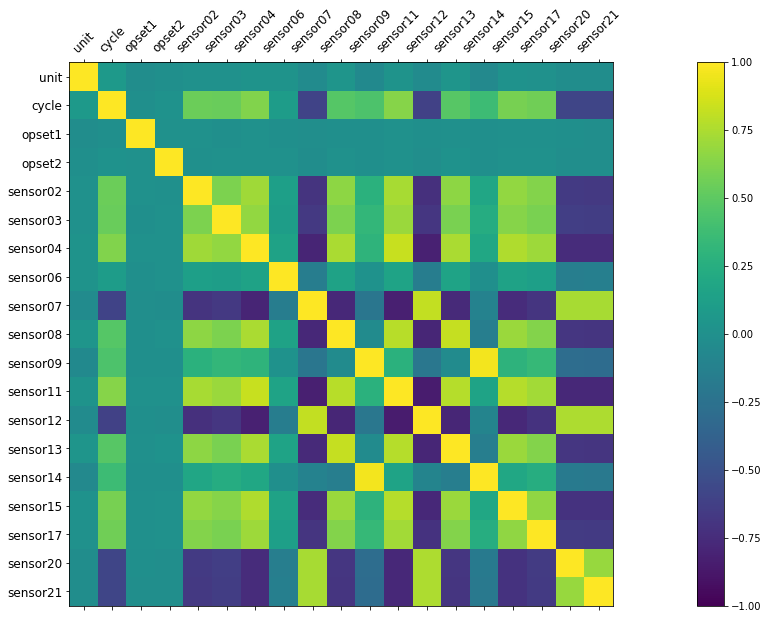

In [30]:
import numpy as np

# can we plot the matrix now?
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations_subset, vmin=-1, vmax=1)
fig.colorbar(cax)

#ensure space for all labels
ax.set_xticks(np.arange(len(df_train_fd001_subset.columns)))
ax.set_yticks(np.arange(len(df_train_fd001_subset.columns)))

# need to rotate the x texts (otherwise they overlap)
ax.set_xticklabels(df_train_fd001_subset.columns, rotation=45, fontsize=12)
ax.set_yticklabels(df_train_fd001_subset.columns, fontsize=12)

plt.show()

Well, sensor 9 seems to have a high correlation with sensor 14; but thats about it. We keep this data; all correlations are below 0.9. We can check later if we can clean more.

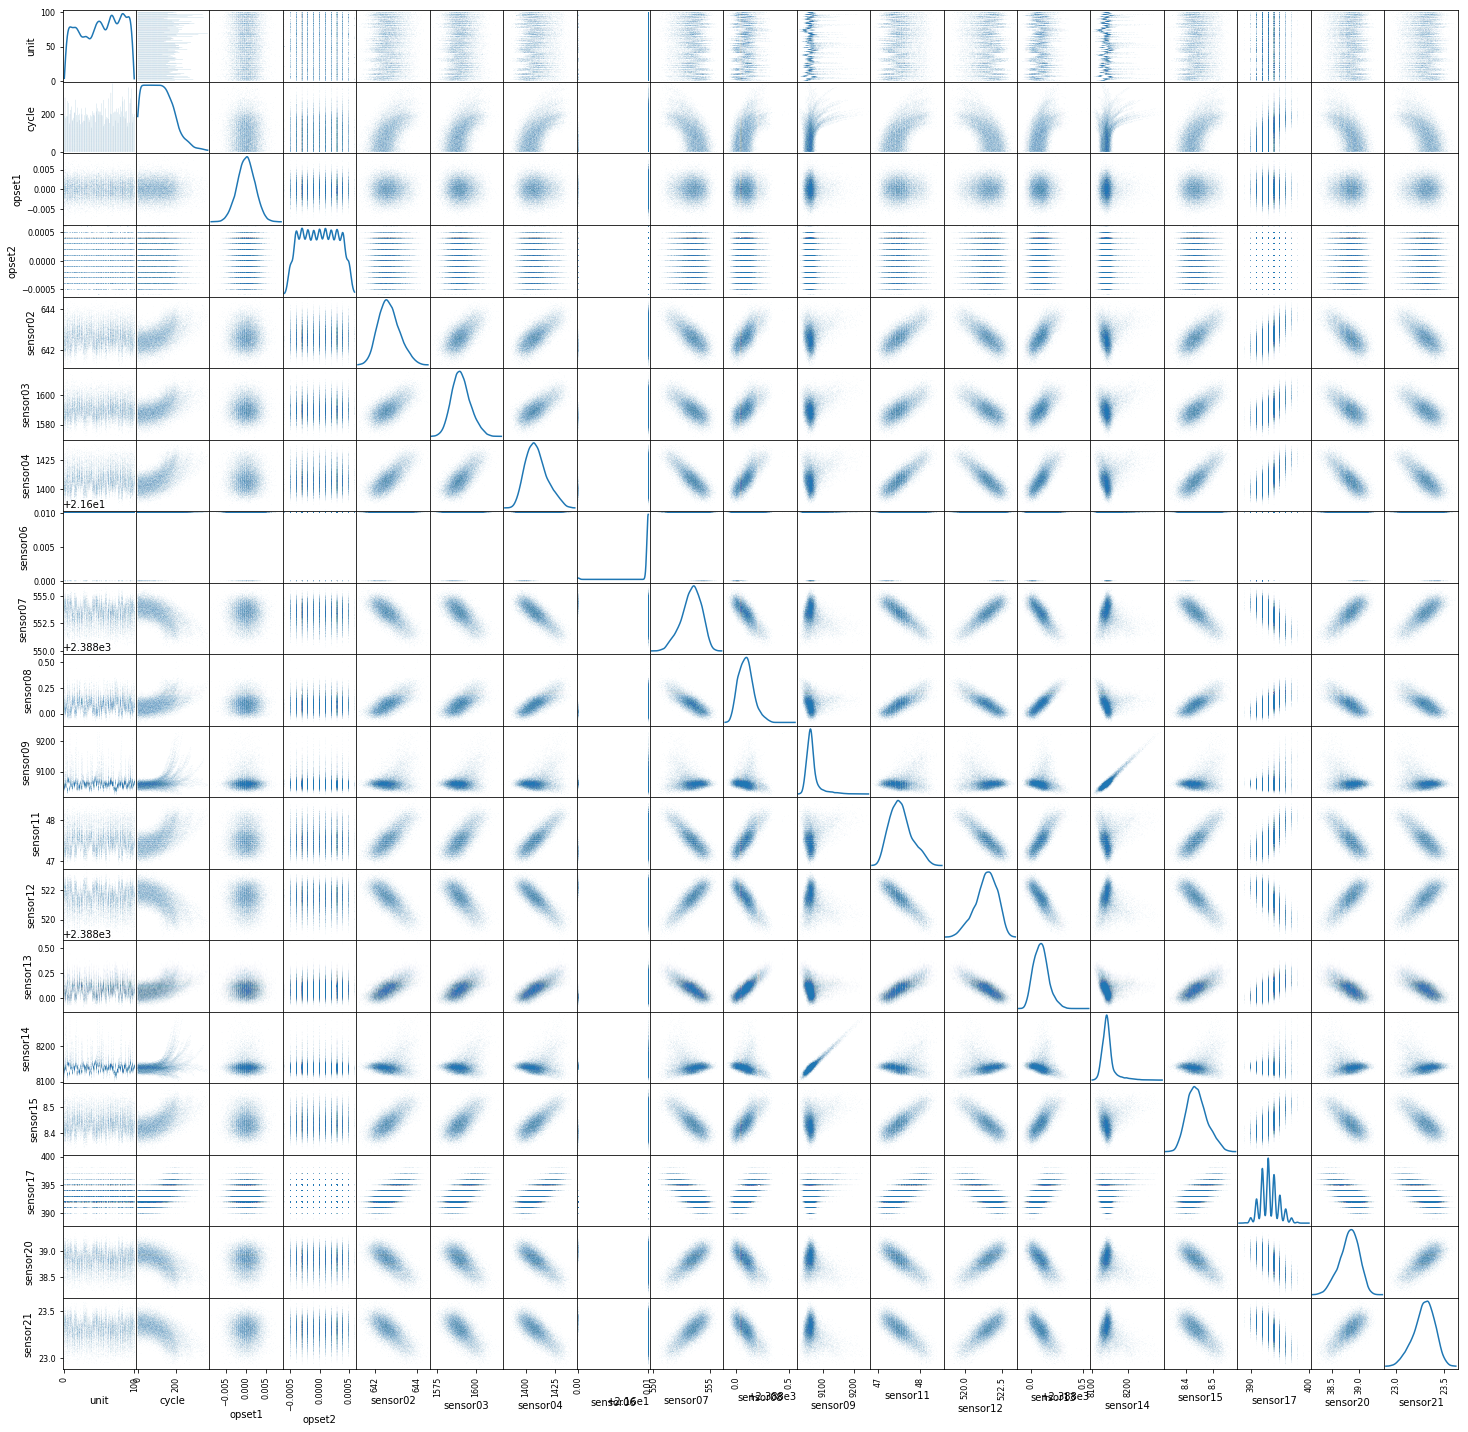

In [31]:
# lets double check with density 
from pandas.plotting import scatter_matrix

scatter_matrix(pd_train_fd001_subset, figsize = [25, 25], marker = ".", s=0.2, diagonal = "kde")
plt.show()

Looking at the scatterplot we get a better idea of the relation between the data, for most sensors the scatterplot looks to have a relation, i.e. there seems to be a pattern; the data does not look randomly spread. A correlation might be expected as one part of the turbine probably influences another part down the chain.<br/>
Also its clear to see that the operational settings only use a few values out of a range, since we see a pattern of lines.<br/>
However the correlation isnt high since most data is spread in both x and y even with a pattern.<br/>

For example, sensor09 and sensor14 do seem to be correlated (looking at this plot) which matches the the 0.96 from the correlation table and <br/>
sensor09 and sensor17 look more like a pattern of lines, and do not look so highly correclated wich matches the 0.34 from the correlaton table.<br/>

To be able to combine the dataset of the several runs (for later) i added two columns: 'Conditions' and 'Fault Modes', the informaton is from the readme text.

### Data sets
| Data Set  | Conditions      | Fault Modes                             |
| --------- | ---------------:|:--------------------------------------  |
| FD001     | ONE (Sea Level) | ONE (HPC Degradation)                   |
| FD002     | SIX             | ONE (HPC Degradation)                   |
| FD003     | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation)  |
| FD004     | SIX             | TWO (HPC Degradation, Fan Degradation)  |



In [32]:
# add the condition and faultmode to the complete first run

# both the 'whole' set
pd_train_fd001['condition']='one'
pd_train_fd001['faultmode']='one'

# and the subset 
pd_train_fd001_subset['condition']='one'
pd_train_fd001_subset['faultmode']='one'

In [33]:
# check
pd_train_fd001_subset.head()

unit  cycle  opset1  opset2    sensor02     sensor03     sensor04   sensor06    sensor07     sensor08    ...      sensor11    sensor12     sensor13     sensor14  sensor15  sensor17   sensor20   sensor21  condition faultmode
0     1      1 -0.0007 -0.0004  641.820007  1589.699951  1400.599976  21.610001  554.359985  2388.060059    ...     47.470001  521.659973  2388.020020  8138.620117    8.4195     392.0  39.060001  23.419001        one       one
1     1      2  0.0019 -0.0003  642.150024  1591.819946  1403.140015  21.610001  553.750000  2388.040039    ...     47.490002  522.280029  2388.070068  8131.490234    8.4318     392.0  39.000000  23.423599        one       one
2     1      3 -0.0043  0.0003  642.349976  1587.989990  1404.199951  21.610001  554.260010  2388.080078    ...     47.270000  522.419983  2388.030029  8133.229980    8.4178     390.0  38.950001  23.344200        one       one
3     1      4  0.0007  0.0000  642.349976  1582.790039  1401.869995  21.610001  554.450012  2388.110107    ...     47.130001  522.859985  2388.080078  8133.830078    8.3682     392.0  38.880001  23.373899        one       one
4     1      5 -0.0019 -0.0002  642.369995  1582.849976  1406.219971  21.610001  554.000000  2388.060059    ...     47.279999  522.190002  2388.040039  8133.799805    8.4294     393.0  38.900002  23.404400        one       one

[5 rows x 21 columns]

For our first approach we want to use a PCA based model. To correctly process we need normalised data. Since the range of sensors like RPM are only positive values i thought it best to use a range from 0..1.

In [34]:
# normalise values..
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))


In [35]:
# first copy cycle so we have one which we can interpret better (we should use that one for modellign though).
pd_train_fd001['cycleoriginal'] = pd_train_fd001['cycle']

In [36]:
# Don't scale the original cycle, engine number (unit), condition or faultmode.
# engine number is related to an engine and both condition and faultmode are related to the selected test scenario.
pd_train_fd001[['cycle','opset1', 'opset2', 'opset3',\
                'sensor01','sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']] \
    = scaler.fit_transform(pd_train_fd001[['cycle','opset1', 'opset2', 'opset3',\
                                           'sensor01','sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']])
pd_train_fd001.head()

unit    cycle    opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05      ...        sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  condition  faultmode  cycleoriginal
0     1  0.00000  0.459770  0.166667     0.0       0.0  0.183730  0.406800  0.309757       0.0      ...        0.363989       0.0  0.333333       0.0       0.0  0.713179  0.724662        one        one              1
1     1  0.00277  0.609195  0.250000     0.0       0.0  0.283133  0.453017  0.352634       0.0      ...        0.411313       0.0  0.333333       0.0       0.0  0.666667  0.731012        one        one              2
2     1  0.00554  0.252874  0.750000     0.0       0.0  0.343359  0.369522  0.370526       0.0      ...        0.357446       0.0  0.166667       0.0       0.0  0.627908  0.621375        one        one              3
3     1  0.00831  0.540230  0.500000     0.0       0.0  0.343359  0.256159  0.331195       0.0      ...        0.166605       0.0  0.333333       0.0       0.0  0.573644  0.662385        one        one              4
4     1  0.01108  0.390805  0.333333     0.0       0.0  0.349389  0.257465  0.404625       0.0      ...        0.402081       0.0  0.416667       0.0       0.0  0.589149  0.704501        one        one              5

[5 rows x 29 columns]

In [37]:
# first copy cycle so we have one which we can interpret better (we should use that one for modeling though).
pd_train_fd001_subset['cycleoriginal'] = pd_train_fd001_subset['cycle']

In [39]:
# Don't scale the engine number, condition or faultmode.
# engine number is related to an engine and both condition and faultmode are related to the selected test scenario.
pd_train_fd001_subset[['cycle','opset1', 'opset2', \
                'sensor02','sensor03','sensor04','sensor06','sensor07','sensor08','sensor09', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor17','sensor20','sensor21']] \
    = scaler.fit_transform(pd_train_fd001_subset[['cycle','opset1', 'opset2', \
                                           'sensor02','sensor03','sensor04','sensor06','sensor07','sensor08','sensor09', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor17','sensor20','sensor21']])
pd_train_fd001_subset.head()

#('opset3', 'sensor01', 'sensor05', 'sensor10', 'sensor16','sensor18','sensor19')

unit    cycle    opset1    opset2  sensor02  sensor03  sensor04  sensor06  sensor07  sensor08      ...       sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  sensor21  condition  faultmode cycleoriginal
0     1  0.00000  0.459770  0.166667  0.183730  0.406800  0.309757       1.0  0.726247  0.242604      ...       0.633256  0.206030  0.199609  0.363989  0.333333  0.713179  0.724662        one        one             1
1     1  0.00277  0.609195  0.250000  0.283133  0.453017  0.352634       1.0  0.628021  0.212278      ...       0.765464  0.279612  0.162815  0.411313  0.333333  0.666667  0.731012        one        one             2
2     1  0.00554  0.252874  0.750000  0.343359  0.369522  0.370526       1.0  0.710148  0.272929      ...       0.795305  0.220747  0.171793  0.357446  0.166667  0.627908  0.621375        one        one             3
3     1  0.00831  0.540230  0.500000  0.343359  0.256159  0.331195       1.0  0.740744  0.318417      ...       0.889122  0.294329  0.174890  0.166605  0.333333  0.573644  0.662385        one        one             4
4     1  0.01108  0.390805  0.333333  0.349389  0.257465  0.404625       1.0  0.668279  0.242604      ...       0.746268  0.235463  0.174734  0.402081  0.416667  0.589149  0.704501        one        one             5

[5 rows x 22 columns]

In [40]:
# also scale the test set for later use 
# TODO use helper functions
pd_test_fd001  = df_test_fd001.toPandas()

# first copy cycle so we have one which we can interpret better (we should use that one for modeling though).
pd_test_fd001['cycleoriginal'] = pd_test_fd001['cycle']

pd_test_fd001[['cycle','opset1', 'opset2', 'opset3',\
                'sensor01','sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']] \
    = scaler.fit_transform(pd_test_fd001[['cycle','opset1', 'opset2', 'opset3',\
                                           'sensor01','sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']])
pd_test_fd001.head()

unit     cycle   opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05      ...        sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  cycleoriginal
0     1  0.000000  0.65625  0.692308     0.0       0.0  0.596222  0.421968  0.282213       0.0      ...        0.325766  0.152257  0.347076       0.0     0.375       0.0       0.0  0.500000  0.620101              1
1     1  0.003311  0.34375  0.230769     0.0       0.0  0.182972  0.504023  0.225241       0.0      ...        0.395573  0.277907  0.227707       0.0     0.500       0.0       0.0  0.645455  0.645719              2
2     1  0.006623  0.53125  0.538462     0.0       0.0  0.419566  0.464812  0.346129       0.0      ...        0.325766  0.192892  0.533559       0.0     0.500       0.0       0.0  0.700001  0.681104              3
3     1  0.009934  0.77500  0.461538     0.0       0.0  0.413251  0.391585  0.449868       0.0      ...        0.372304  0.217894  0.282358       0.0     0.250       0.0       0.0  0.627272  0.620382              4
4     1  0.013245  0.60000  0.461538     0.0       0.0  0.435335  0.471303  0.357975       0.0      ...        0.325766  0.187890  0.337009       0.0     0.125       0.0       0.0  0.618183  0.676009              5

[5 rows x 27 columns]

In [41]:
# store pandas data fame 1
from pandas import HDFStore

store = HDFStore('pd_train_fd001_scaled.h5', mode='w')
store['pd'] = pd_train_fd001
store.close()

store = HDFStore('pd_train_fd001_subset_scaled.h5', mode='w')
store['pd'] = pd_train_fd001_subset
store.close()

store = HDFStore('pd_test_fd001_scaled.h5', mode='w')
store['pd'] = pd_test_fd001
store.close()


In [42]:
!ls -l  *.h5

-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 2942744 Feb 26 15:04 pd_test_fd001_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 5764072 Feb 26 15:04 pd_train_fd001_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 4608736 Feb 26 15:04 pd_train_fd001_subset_scaled.h5


# Data set FD002, second dataset of the 4.

Just to have a quick peek at the next dataset, same type of engines, different conditions. So we basically follow the same steps as for data set 1, FD001.<br/>
For now, we wont look into the data in much detail.


In [43]:
# TODO use helper methods
df_train_fd002 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/train_FD002.txt', schema=schema)
df_train_fd002.head()

# also test for later
df_test_fd002 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/test_FD002.txt', schema=schema)

In [44]:
# Check for missing data
print('Total number of rows in dataset {0}.'.format( df_train_fd002.count()))

# check for each column
from pyspark.sql.functions import col,sum
df_train_fd002.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_train_fd002.columns)).show()

Total number of rows in dataset 53759.
+----+-----+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|unit|cycle|opset1|opset2|opset3|sensor01|sensor02|sensor03|sensor04|sensor05|sensor06|sensor07|sensor08|sensor09|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|
+----+-----+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   0|    0|     0|     0|     0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
+----+-----+------+------+------+--------+--------+--------+--------+

In [45]:
# stats of each column, gets messy so we go trhough subsets
df_train_fd002.select('unit', 'cycle','opset1','opset2','opset3').describe().show()

+-------+------------------+------------------+------------------+-------------------+------------------+
|summary|              unit|             cycle|            opset1|             opset2|            opset3|
+-------+------------------+------------------+------------------+-------------------+------------------+
|  count|             53759|             53759|             53759|              53759|             53759|
|   mean|131.08298145426812|109.15474618203464|23.998407469006366| 0.5720563471695806| 94.04602020126862|
| stddev| 74.46386155011544| 69.18056859296168|14.747376125739223|0.31001597846723855|14.237734626001536|
|    min|                 1|                 1|               0.0|                0.0|              60.0|
|    max|               260|               378|            42.008|              0.842|             100.0|
+-------+------------------+------------------+------------------+-------------------+------------------+



In [46]:
# stats of each column, gets messy so we go trhough subsets
df_train_fd002.select('sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10').describe().show()

+-------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|summary|          sensor01|         sensor02|          sensor03|          sensor04|         sensor05|          sensor06|          sensor07|          sensor08|          sensor09|           sensor10|
+-------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|  count|             53759|            53759|             53759|             53759|            53759|             53759|             53759|             53759|             53759|              53759|
|   mean|472.91020464533045|579.6723993841711|1419.9710132020773|1205.4420243696113| 8.03198624822732|11.600745913284285|  282.606786777967|2228.8791864038535|  8525.20083857325| 1.0949615779830693|
| std

In [47]:
# stats of each column, gets messy so we go trhough subsets
df_train_fd002.select('sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21').describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|          sensor11|          sensor12|          sensor13|         sensor14|          sensor15|            sensor16|          sensor17|          sensor18|         sensor19|          sensor20|          sensor21|
+-------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             53759|             53759|             53759|            53759|             53759|               53759|             53759|             53759|            53759|             53759|             53759|
|   mean|42.985172338855946| 266.0690344129969| 2334.557257039319|8066.597682217673| 9.329653543904325|0.023325954202484473|

No static data. For now keep all.

In [50]:
pd_train_fd002 = df_train_fd002.toPandas()

pd_train_fd002['condition']='six'
pd_train_fd002['faultmode']='one'

# first copy cycle so we have one which we can interpret better (we should use that one for modeling though).
pd_train_fd002['cycleoriginal'] = pd_train_fd002['cycle']

# again, only scale sensor data. 
pd_train_fd002[['cycle','opset1', 'opset2', 'opset3',\
                'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']] \
    = scaler.fit_transform(pd_train_fd002[['cycle','opset1', 'opset2', 'opset3',\
                                           'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']])
pd_train_fd002.head()

unit     cycle    opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05      ...        sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  condition  faultmode  cycleoriginal
0     1  0.000000  0.833134  0.997625     1.0  0.060269  0.181576  0.311201  0.273095  0.146592      ...        0.369947       0.0  0.322917  0.651163       1.0  0.156036  0.159082        six        one              1
1     1  0.002653  0.999767  0.998575     1.0  0.000000  0.131847  0.296600  0.245535  0.000000      ...        0.381408       0.0  0.281250  0.627907       1.0  0.007888  0.014562        six        one              2
2     1  0.005305  0.595096  0.738480     0.0  0.238089  0.016331  0.035297  0.056997  0.293184      ...        0.936731       0.0  0.062500  0.000000       0.0  0.133745  0.151414        six        one              3
3     1  0.007958  0.999993  0.999525     1.0  0.000000  0.128268  0.298795  0.246979  0.000000      ...        0.372401       0.0  0.270833  0.627907       1.0  0.014060  0.026144        six        one              4
4     1  0.010610  0.595137  0.736698     0.0  0.238089  0.014130  0.037871  0.058152  0.293184      ...        0.937537       0.0  0.062500  0.000000       0.0  0.135460  0.143240        six        one              5

[5 rows x 29 columns]

In [51]:
pd_test_fd002 = df_test_fd002.toPandas()

# first copy cycle so we have one which we can interpret better (we should use that one for modeling though).
pd_test_fd002['cycleoriginal'] = pd_test_fd002['cycle']

# again, only scale sensor data. 
pd_test_fd002[['cycle','opset1', 'opset2', 'opset3',\
                'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']] \
    = scaler.fit_transform(pd_test_fd002[['cycle','opset1', 'opset2', 'opset3',\
                                           'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']])
pd_test_fd002.head()

unit     cycle    opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05      ...        sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  cycleoriginal
0     1  0.000000  0.238019  0.297150     1.0  0.597937  0.639244  0.691329  0.680395  0.617180      ...        0.995085  0.670743  0.117564       1.0  0.694737  0.854123       1.0  0.625944  0.630724              1
1     1  0.002732  0.476162  0.831354     1.0  0.626985  0.664861  0.647519  0.534663  0.507937      ...        0.994920  0.514945  0.337173       0.0  0.642105  0.864693       1.0  0.484214  0.496301              2
2     1  0.005464  0.833282  0.997625     1.0  0.060269  0.189055  0.312512  0.243225  0.146592      ...        0.993898  0.514894  0.376695       0.0  0.315789  0.651163       1.0  0.164722  0.159476              3
3     1  0.008197  0.999967  0.998812     1.0  0.000000  0.135525  0.286753  0.242061  0.000000      ...        0.993815  0.550270  0.394807       0.0  0.305263  0.627907       1.0  0.005834  0.016866              4
4     1  0.010929  0.595089  0.737886     0.0  0.238089  0.012028  0.022001  0.050986  0.293184      ...        0.000718  0.036627  0.940070       0.0  0.021053  0.000000       0.0  0.141730  0.140124              5

[5 rows x 27 columns]

In [52]:
# since we have many features a correlation matrix or scatterplot is hard to get plotted.
# a 25 * 25 comparison results in 625 figures, perhaps use a subset? 
# or just the matrix 
pd.set_option('display.width', 800) # doesnt help to show all at once

correlations = pd_train_fd002.corr()
#print(correlations) # --> results in unreable table

In [53]:
# drop one halve of the matrix
corr_triu = correlations.where(~np.tril(np.ones(correlations.shape)).astype(np.bool))
corr_triu = corr_triu.stack()

# drop correlations below 0.3
corr_triu[corr_triu > 0.3]

cycle     cycleoriginal    1.000000
opset1    opset2           0.943005
          sensor15         0.460837
opset2    sensor15         0.520009
opset3    sensor02         0.480073
          sensor03         0.620839
          sensor04         0.544563
          sensor07         0.306989
          sensor08         0.902746
          sensor09         0.634739
          sensor10         0.508645
          sensor11         0.800034
          sensor12         0.308334
          sensor13         0.999998
          sensor14         0.927377
          sensor17         0.617185
          sensor18         0.902999
          sensor19         1.000000
sensor01  sensor02         0.944089
          sensor03         0.870963
          sensor04         0.898002
          sensor05         0.986372
          sensor06         0.986424
          sensor07         0.973142
          sensor08         0.572652
          sensor09         0.861836
          sensor10         0.826591
          sensor11         0

We might consider dropping related data with correlation above 90% (0.9). 

**TODO one more run with a subset **

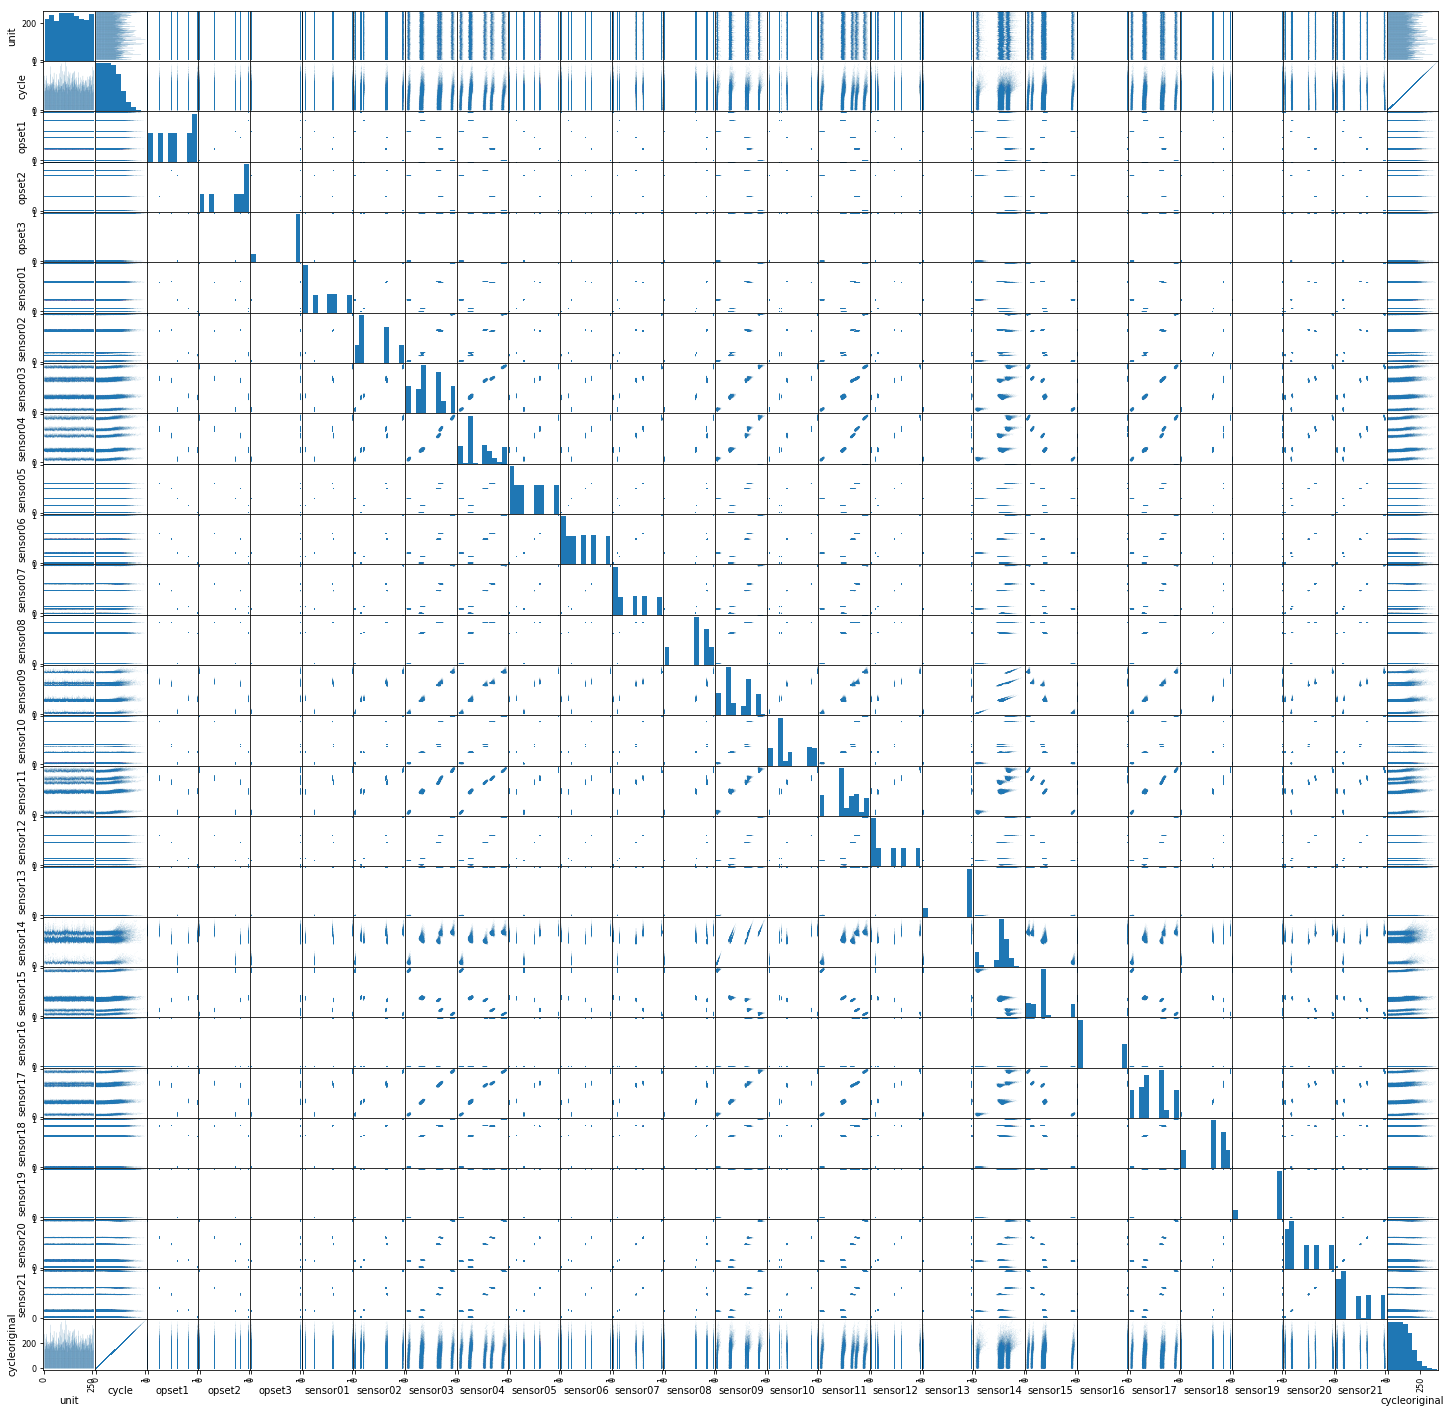

In [54]:
# Quick check .. on the data correlation 
from pandas.plotting import scatter_matrix

scatter_matrix(pd_train_fd002, figsize = [25, 25], marker = ".", s=0.2, diagonal = "hist")
plt.show()

The relations between the sensors seem less structured, compared to the scatterplot of dataset FD001.

In [55]:
store = HDFStore('pd_train_fd002_scaled.h5', mode='w')
store['pd'] = pd_train_fd002
store.close()

store = HDFStore('pd_test_fd002_scaled.h5', mode='w')
store['pd'] = pd_test_fd002
store.close()

# FD003, data set 3

In [56]:
# TODO use helper methods
df_train_fd003 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/train_FD003.txt', schema=schema)
df_train_fd003.head()

df_test_fd003 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/test_FD003.txt', schema=schema)
#df_test_fd003.head()


# Check for missing data
print('Total number of rows in dataset {0}.'.format( df_train_fd003.count()))

# check for each column
from pyspark.sql.functions import col,sum
print(df_train_fd003.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_train_fd003.columns)).show())

pd_train_fd003 = df_train_fd003.toPandas()

pd_train_fd003['condition']='one'
pd_train_fd003['faultmode']='two'

pd_train_fd003['cycleoriginal'] = pd_train_fd003['cycle']

pd_train_fd003[['cycle','opset1', 'opset2', 'opset3',\
                'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']] \
    = scaler.fit_transform(pd_train_fd003[['cycle','opset1', 'opset2', 'opset3',\
                                           'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']])
pd_train_fd003.head()

Total number of rows in dataset 24720.
+----+-----+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|unit|cycle|opset1|opset2|opset3|sensor01|sensor02|sensor03|sensor04|sensor05|sensor06|sensor07|sensor08|sensor09|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|
+----+-----+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   0|    0|     0|     0|     0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
+----+-----+------+------+------+--------+--------+--------+--------+

unit     cycle    opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05      ...        sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  condition  faultmode  cycleoriginal
0     1  0.000000  0.470930  0.769231     0.0       0.0  0.355966  0.370522  0.308579       0.0      ...        0.647754       0.0  0.272727       0.0       0.0  0.559525  0.446331        one        two              1
1     1  0.001908  0.546512  0.230769     0.0       0.0  0.388756  0.399098  0.309360       0.0      ...        0.685659       0.0  0.363636       0.0       0.0  0.488097  0.534836        one        two              2
2     1  0.003817  0.418605  0.307692     0.0       0.0  0.313812  0.353297  0.445397       0.0      ...        0.564460       0.0  0.272727       0.0       0.0  0.404762  0.458576        one        two              3
3     1  0.005725  0.383721  0.538462     0.0       0.0  0.487114  0.417106  0.237285       0.0      ...        0.558909       0.0  0.363636       0.0       0.0  0.470239  0.391965        one        two              4
4     1  0.007634  0.593023  0.461538     0.0       0.0  0.196715  0.476218  0.321216       0.0      ...        0.556736       0.0  0.363636       0.0       0.0  0.577382  0.543371        one        two              5

[5 rows x 29 columns]

In [57]:
# TODO helper methods
pd_test_fd003 = df_test_fd003.toPandas()

pd_test_fd003['cycleoriginal'] = pd_test_fd003['cycle']

pd_test_fd003[['cycle','opset1', 'opset2', 'opset3',\
                'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']] \
    = scaler.fit_transform(pd_test_fd003[['cycle','opset1', 'opset2', 'opset3',\
                                           'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']])
pd_test_fd003.head()

unit     cycle    opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05      ...        sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  cycleoriginal
0     1  0.000000  0.411765  0.166667     0.0       0.0  0.330132  0.400715  0.345270       0.0      ...        0.628896  0.326194  0.531662       0.0  0.363636       0.0       0.0  0.524475  0.503085              1
1     1  0.002110  0.547059  0.333333     0.0       0.0  0.355778  0.470393  0.384026       0.0      ...        0.672962  0.372278  0.621866       0.0  0.363636       0.0       0.0  0.503497  0.544905              2
2     1  0.004219  0.594118  0.250000     0.0       0.0  0.246797  0.397148  0.246706       0.0      ...        0.628896  0.381705  0.469833       0.0  0.363636       0.0       0.0  0.545454  0.475451              3
3     1  0.006329  0.670588  0.583333     0.0       0.0  0.413467  0.462546  0.313987       0.0      ...        0.641486  0.367971  0.516429       0.0  0.454545       0.0       0.0  0.454546  0.541822              4
4     1  0.008439  0.505882  0.583333     0.0       0.0  0.496802  0.569561  0.324218       0.0      ...        0.647781  0.334576  0.646955       0.0  0.363636       0.0       0.0  0.538462  0.439182              5

[5 rows x 27 columns]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


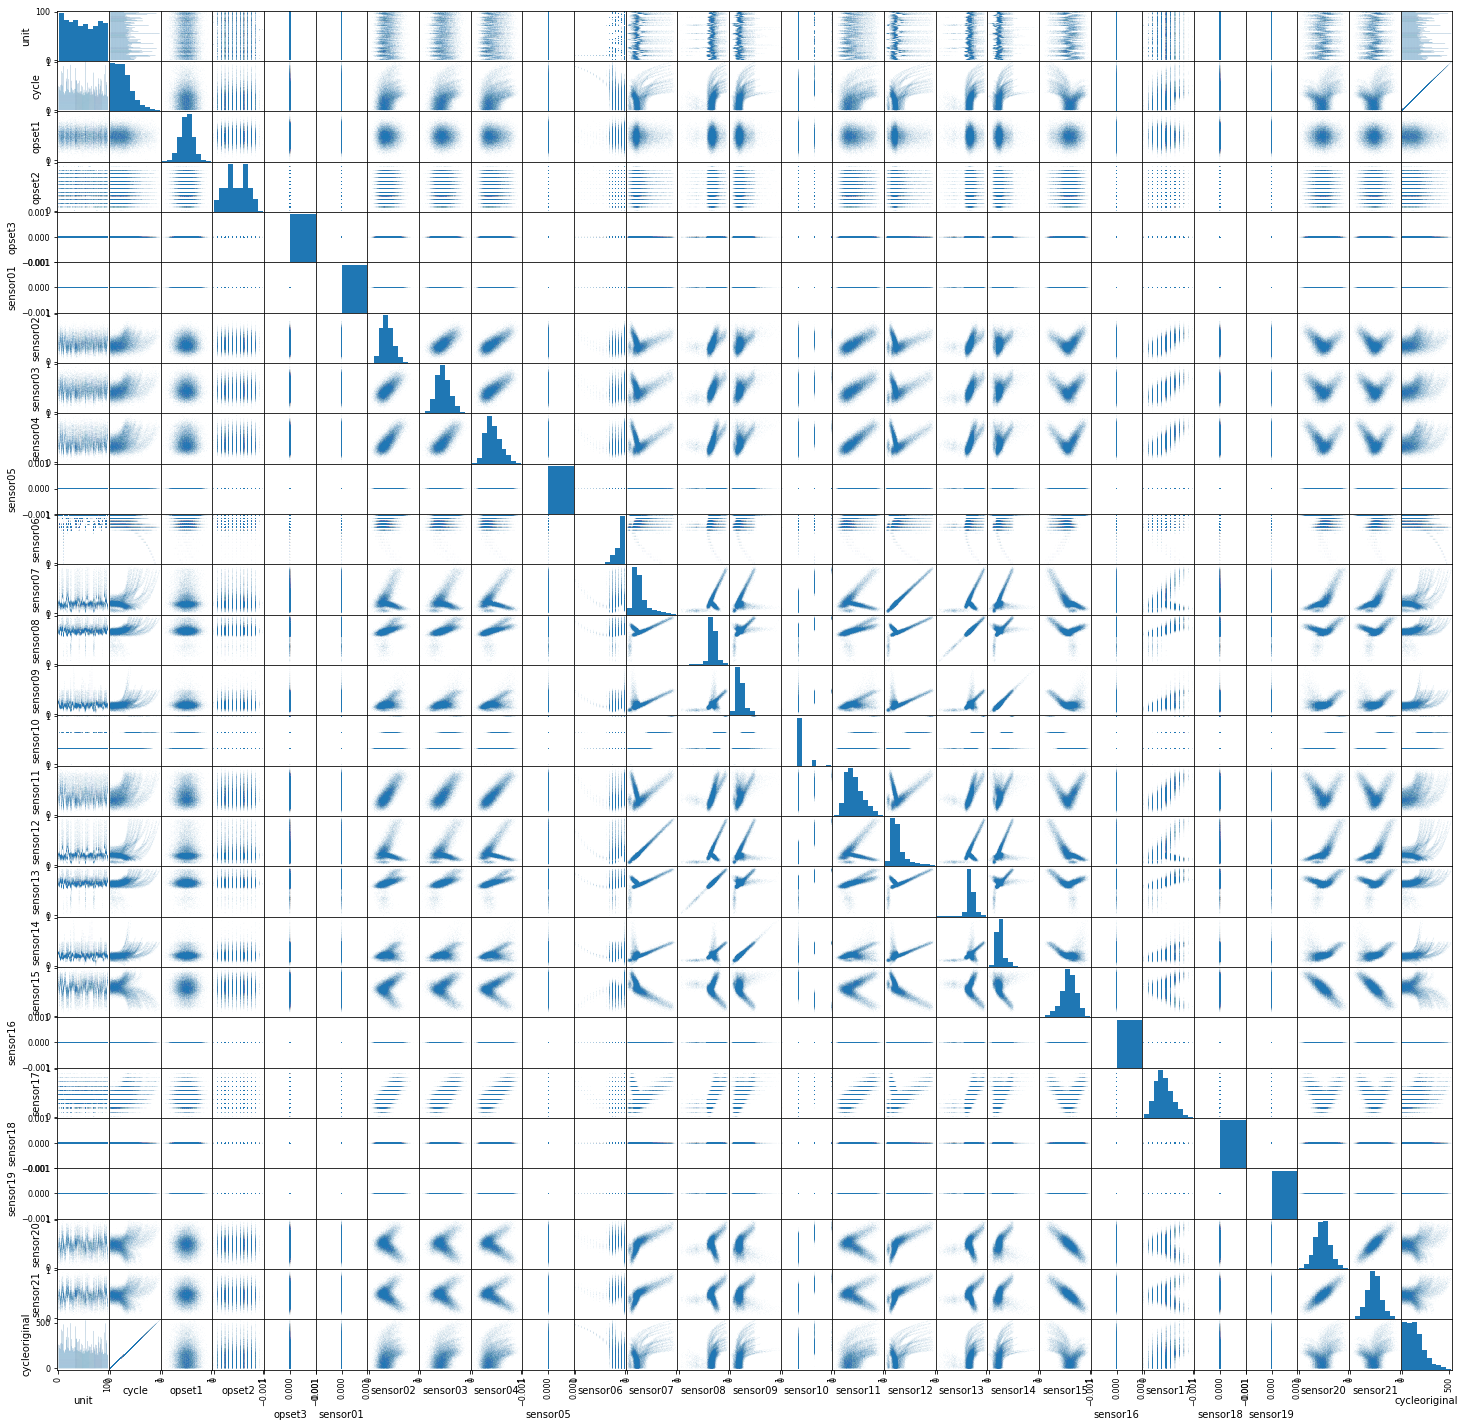

In [58]:
# Quick check .. on the data correlation 
from pandas.plotting import scatter_matrix

scatter_matrix(pd_train_fd003, figsize = [25, 25], marker = ".", s=0.2, diagonal = "hist")
plt.show()

So FD001 and FD003 look a lot like each other, likely since the conditions of the test are the same.

In [59]:
# table above is unreabe, and skipped some data... another way (... dropping the assumed 1.- correlation of a variable with itslef)
correlations = pd_train_fd003.corr()
#correlations.unstack().sort_values().drop_duplicates()

# drop one halve of the matrix
corr_triu = correlations.where(~np.tril(np.ones(correlations.shape)).astype(np.bool))
corr_triu = corr_triu.stack()

# drop correlations below 0.3
corr_triu[corr_triu > 0.3]

cycle     sensor02         0.300798
          sensor03         0.373506
          sensor04         0.361937
          sensor07         0.531015
          sensor08         0.438065
          sensor09         0.507838
          sensor10         0.528220
          sensor11         0.407412
          sensor12         0.538197
          sensor13         0.437520
          sensor14         0.488564
          sensor17         0.386185
          sensor20         0.304585
          sensor21         0.311020
          cycleoriginal    1.000000
sensor02  sensor03         0.640503
          sensor04         0.745167
          sensor06         0.314800
          sensor08         0.533901
          sensor09         0.441282
          sensor11         0.762269
          sensor13         0.532738
          sensor14         0.343954
          sensor17         0.670062
          cycleoriginal    0.300798
sensor03  sensor04         0.716890
          sensor08         0.637917
          sensor09         0

In [60]:
store = HDFStore('pd_train_fd003_scaled.h5', mode='w')
store['pd'] = pd_train_fd003
store.close()

store = HDFStore('pd_test_fd003_scaled.h5', mode='w')
store['pd'] = pd_test_fd003
store.close()

# Dataset 4, FD004

In [61]:
# TODO use helper methods
df_train_fd004 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/train_FD004.txt', schema=schema)
df_train_fd004.head()

df_test_fd004 = spark.read.option("header", "false").option("delimiter", " ").csv('rul-cmapssdata/test_FD004.txt', schema=schema)


# Check for missing data
print('Total number of rows in dataset {0}.'.format( df_train_fd004.count()))

# check for each column
from pyspark.sql.functions import col,sum
print(df_train_fd004.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_train_fd004.columns)).show())

pd_train_fd004 = df_train_fd004.toPandas()

pd_train_fd004['condition']='six'
pd_train_fd004['faultmode']='two'

pd_train_fd004['cycleoriginal'] = pd_train_fd004['cycle']

pd_train_fd004[['cycle','opset1', 'opset2', 'opset3',\
                'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']] \
    = scaler.fit_transform(pd_train_fd004[['cycle','opset1', 'opset2', 'opset3',\
                                           'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']])
pd_train_fd004.head()

Total number of rows in dataset 61249.
+----+-----+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|unit|cycle|opset1|opset2|opset3|sensor01|sensor02|sensor03|sensor04|sensor05|sensor06|sensor07|sensor08|sensor09|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|
+----+-----+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   0|    0|     0|     0|     0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|       0|
+----+-----+------+------+------+--------+--------+--------+--------+

unit     cycle    opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05      ...        sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  condition  faultmode  cycleoriginal
0     1  0.000000  0.999926  0.997625     1.0  0.000000  0.130347  0.272082  0.212586  0.000000      ...        0.400540       0.0  0.288660  0.627907       1.0  0.015473  0.015881        six        two              1
1     1  0.001845  0.476147  0.831591     1.0  0.626985  0.647972  0.634407  0.511781  0.507937      ...        0.351346       0.0  0.608247  0.864693       1.0  0.477968  0.481487        six        two              2
2     1  0.003690  0.999900  0.998694     1.0  0.000000  0.123646  0.271244  0.222481  0.000000      ...        0.423787       0.0  0.278351  0.627907       1.0  0.010764  0.018932        six        two              3
3     1  0.005535  0.999810  0.997625     1.0  0.000000  0.121351  0.266168  0.224835  0.000000      ...        0.401716       0.0  0.268041  0.627907       1.0  0.012782  0.018724        six        two              4
4     1  0.007380  0.595275  0.737173     0.0  0.238089  0.005691  0.033916  0.022025  0.293184      ...        0.920536       0.0  0.030928  0.000000       0.0  0.130172  0.145560        six        two              5

[5 rows x 29 columns]

In [62]:
# TODO helper
pd_test_fd004 = df_test_fd004.toPandas()

pd_test_fd004['cycleoriginal'] = pd_test_fd004['cycle']
pd_test_fd004[['cycle','opset1', 'opset2', 'opset3',\
                'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']] \
    = scaler.fit_transform(pd_test_fd004[['cycle','opset1', 'opset2', 'opset3',\
                                           'sensor01', 'sensor02','sensor03','sensor04','sensor05','sensor06','sensor07','sensor08','sensor09','sensor10', \
                                           'sensor11', 'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']])
pd_test_fd004.head()

unit     cycle    opset1    opset2  opset3  sensor01  sensor02  sensor03  sensor04  sensor05      ...        sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  cycleoriginal
0     1  0.000000  0.476271  0.831354     1.0  0.626985  0.656561  0.654027  0.501557  0.507937      ...        0.996017  0.574006  0.362211       0.0  0.631579  0.864693       1.0  0.478320  0.483780              1
1     1  0.002062  0.595087  0.736342     0.0  0.238089  0.007372  0.041486  0.016264  0.293184      ...        0.000968  0.039366  0.945325       0.0  0.042105  0.000000       0.0  0.141260  0.137380              2
2     1  0.004124  0.999810  1.000000     1.0  0.000000  0.127258  0.270192  0.200168  0.000000      ...        0.996487  0.637839  0.423747       0.0  0.273684  0.627907       1.0  0.006775  0.016466              3
3     1  0.006186  0.999893  0.997862     1.0  0.000000  0.126889  0.269020  0.203579  0.000000      ...        0.996348  0.660203  0.410736       0.0  0.273684  0.627907       1.0  0.012534  0.005168              4
4     1  0.008247  0.833363  0.997625     1.0  0.060269  0.181349  0.305358  0.229632  0.146592      ...        0.996266  0.599511  0.390686       0.0  0.326316  0.651163       1.0  0.157859  0.157613              5

[5 rows x 27 columns]

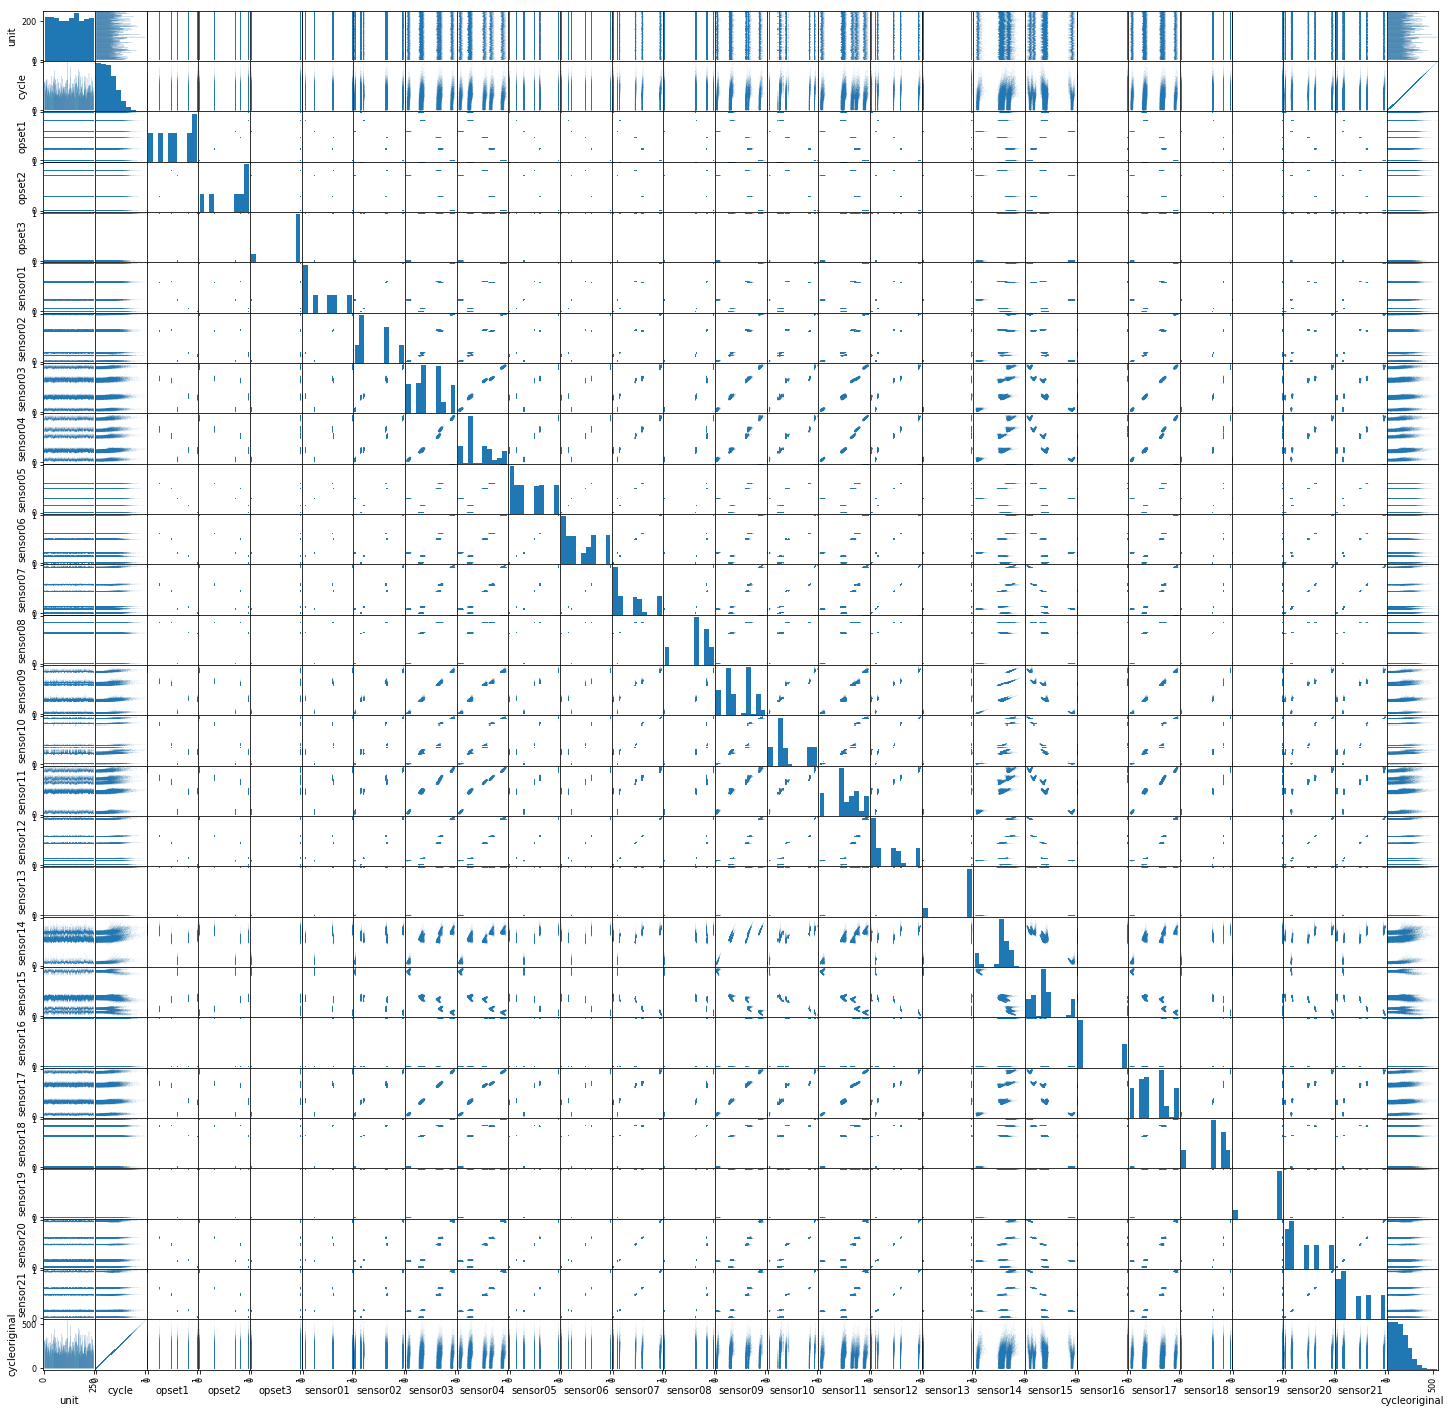

In [63]:
# Quick check .. on the data correlation 
from pandas.plotting import scatter_matrix

scatter_matrix(pd_train_fd004, figsize = [25, 25], marker = ".", s=0.2, diagonal = "hist")
plt.show()

So FD002 and FD004 look a lot like each other, likely since the conditions of the tests are the same.

In [64]:
# table above is unreabe, and skipped some data... another way (... dropping the assumed 1.- correlation of a variable with itslef)
correlations = pd_train_fd004.corr()
#correlations.unstack().sort_values().drop_duplicates()

# drop one halve of the matrix
corr_triu = correlations.where(~np.tril(np.ones(correlations.shape)).astype(np.bool))
corr_triu = corr_triu.stack()

# drop correlations below 0.3
corr_triu[corr_triu > 0.3]

cycle     cycleoriginal    1.000000
opset1    opset2           0.943796
          sensor15         0.460800
opset2    sensor15         0.520309
opset3    sensor02         0.478659
          sensor03         0.620181
          sensor04         0.544482
          sensor07         0.306687
          sensor08         0.902625
          sensor09         0.634634
          sensor10         0.514065
          sensor11         0.798813
          sensor12         0.308038
          sensor13         0.999998
          sensor14         0.928067
          sensor17         0.616473
          sensor18         0.902830
          sensor19         1.000000
sensor01  sensor02         0.944439
          sensor03         0.870605
          sensor04         0.897421
          sensor05         0.986561
          sensor06         0.986539
          sensor07         0.973191
          sensor08         0.572469
          sensor09         0.861569
          sensor10         0.823653
          sensor11         0

In [65]:
store = HDFStore('pd_train_fd004_scaled.h5', mode='w')
store['pd'] = pd_train_fd004
store.close()

store = HDFStore('pd_test_fd004_scaled.h5', mode='w')
store['pd'] = pd_test_fd004
store.close()


In [66]:
!ls -l *.h5

-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  2942744 Feb 26 15:04 pd_test_fd001_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  7623224 Feb 26 15:18 pd_test_fd002_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  3726744 Feb 26 15:24 pd_test_fd003_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  9241176 Feb 26 15:36 pd_test_fd004_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  5764072 Feb 26 15:04 pd_train_fd001_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  4608736 Feb 26 15:04 pd_train_fd001_subset_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 13317408 Feb 26 15:18 pd_train_fd002_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users  6696384 Feb 26 15:24 pd_train_fd003_scaled.h5
-rw-------. 1 s5f2-ed0d621fb5609a-59d70c7001d7 users 15025160 Feb 26 15:36 pd_train_fd004_scaled.h5


Next step is to determine how long the engine was running before it failed, for each set we need to find the maximum cycle for each engine and run.
I.e. for each engine, cylcle combination.